In [13]:
import seaborn as sns
import collections as col
import pandas as pd
import statistics
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from pathlib import Path
import gseapy as gp
import functions_sheet as myfunc
from gseapy import barplot, dotplot
import re
import upsetplot as usp
from collections import Counter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from gseapy import Msigdb
from gseapy import GSEA

path_to_main_comparison_dir = "/nfs/data3/IHEC/TF_PRIO/comparisons/cells"
path_to_all_tfs_file = "/nfs/data3/IHEC/TF_PRIO/additional_files/all_tfs.txt"
path_to_figure_folder = "/nfs/data3/IHEC/TF_PRIO/created_plots/8_H3K27ac_analysis"

In [14]:
tf_hm_df = myfunc.read_out_top_tfs_per_hm_tpm_filter(path_to_main_comparison_dir, tpm_filter=1)

In [15]:
tf_hm_df_k27ac = tf_hm_df[["H3K27ac"]]
tf_hm_df_k27ac.applymap(lambda x: len(x))

H3K27ac
macrophage-healthy-neutrophil-healthy       21
macrophage-healthy-monocyte-healthy         11
b-cells-healthy-t-cell-healthy              37
macrophage-healthy-t-cell-healthy            7
b-cells-healthy-monocyte-healthy             9
monocyte-healthy-neutrophil-healthy         22
t-cell-healthy-neutrophil-healthy            6
b-cells-healthy-macrophage-healthy           0
b-cells-healthy-b-cells-leukemia            59
monocyte-healthy-t-cell-healthy              9
b-cells-healthy-neutrophil-healthy          29

## applying no TPM filter to assess how many TFs were lost due to TPM filtering

In [5]:
tf_hm_tpm_0_df = myfunc.read_out_top_tfs_per_hm_tpm_filter(path_to_main_comparison_dir, tpm_filter=0)
tf_hm_tpm_0_df_k27ac = tf_hm_tpm_0_df[["H3K27ac"]]
tf_hm_tpm_0_df_k27ac.applymap(lambda x: len(x))

H3K27ac
macrophage-healthy-neutrophil-healthy       58
macrophage-healthy-monocyte-healthy         43
b-cells-healthy-t-cell-healthy              86
macrophage-healthy-t-cell-healthy           16
b-cells-healthy-monocyte-healthy            22
monocyte-healthy-neutrophil-healthy         67
t-cell-healthy-neutrophil-healthy           35
b-cells-healthy-macrophage-healthy           0
b-cells-healthy-b-cells-leukemia           144
monocyte-healthy-t-cell-healthy             28
b-cells-healthy-neutrophil-healthy          50

In [6]:
tf_hm_k27ac_percentage_remaining = round((tf_hm_df_k27ac.applymap(lambda x: len(x)) /tf_hm_tpm_0_df_k27ac.applymap(lambda x: len(x)))*100,2)
tf_hm_k27ac_percentage_remaining

H3K27ac
macrophage-healthy-neutrophil-healthy    36.21
macrophage-healthy-monocyte-healthy      25.58
b-cells-healthy-t-cell-healthy           43.02
macrophage-healthy-t-cell-healthy        43.75
b-cells-healthy-monocyte-healthy         40.91
monocyte-healthy-neutrophil-healthy      32.84
t-cell-healthy-neutrophil-healthy        17.14
b-cells-healthy-macrophage-healthy         NaN
b-cells-healthy-b-cells-leukemia         40.97
monocyte-healthy-t-cell-healthy          32.14
b-cells-healthy-neutrophil-healthy       58.00

## Removing rows with empty sets

In [16]:
tf_hm_df_k27ac = tf_hm_df_k27ac[tf_hm_df_k27ac["H3K27ac"].apply(lambda x: len(x) > 0)]

In [5]:
tf_hm_df_k27ac

H3K27ac
macrophage-healthy-neutrophil-healthy  {STAT6, ELK4, NFATC2, ELF5, MSANTD3, STAT4, ST...
macrophage-healthy-monocyte-healthy    {CBFB, RBPJ, PRDM4, FOS::JUNB, KLF11, TBP, EBF...
b-cells-healthy-t-cell-healthy         {RUNX3, NR4A1, GMEB2, HIC2, NFE2L1, NEUROD1, P...
macrophage-healthy-t-cell-healthy        {RBPJ, ZBTB48, KLF5, STAT3, GATA3, ZNF384, ZFX}
b-cells-healthy-monocyte-healthy       {VEZF1, FOS::JUNB, EBF1, NR2C1, BATF3, ELF2, Z...
monocyte-healthy-neutrophil-healthy    {ELK4, NFE2L2, FOSL1::JUND, TFAP4, ZBTB12, ELF...
t-cell-healthy-neutrophil-healthy      {CBFB, MYOD1, SP1, ZBTB26, TCF7L2, STAT1, FOXK...
b-cells-healthy-b-cells-leukemia       {TCF12, NR4A1, STAT6, MYB, SMAD4, MEF2A, KLF10...
monocyte-healthy-t-cell-healthy        {TCF7L2, RELA, STAT1::STAT2, ZNF784, ELF5, ZNF...
b-cells-healthy-neutrophil-healthy     {STAT6, ELK4, MAZ, CEBPG, ZNF317, ELF5, KLF3, ...

# obtain HK27ac generalistic TFs

In [6]:
def read_out_generalistic_TFs(tf_df, selected_column = "H3K27ac", occurence_limit = 8):
    """Takes a dataframe with the TFs as input. 
    The input df needs to have the selected column name for the function to work.
    The input df should be created using the create_top_tf_df_with_tpm function.
    Returns two lists of TFs, that occur at least X times (set by the "occurence_limit" parameter) in all comparison
    """
    list_all_tf_selected_column = [tf for tf_set in tf_df[selected_column] for tf in tf_set]
    tf_counter_active_markers = Counter(list_all_tf_selected_column)
    generalistic_TFs = [TF for TF, count in tf_counter_active_markers.items() if count >= occurence_limit ]

    return generalistic_TFs

In [7]:
H3K27ac_generalistic_TFs = read_out_generalistic_TFs(tf_hm_df_k27ac, "H3K27ac", 9)
H3K27ac_generalistic_TFs

[]

No generalistic TFs obtained by using the same threshold as for the generalistic TFs for active and suppressive marks.

## Proof that the function works 

In [10]:
H3K27ac_generalistic_TFs_with_lower_limit = read_out_generalistic_TFs(tf_hm_df, "H3K27ac", 5)
H3K27ac_generalistic_TFs_with_lower_limit

['ELF5', 'ZNF768']

# H3K27ac cell type specific TFs

In [5]:
cell_types = ["b-cells-healthy", "macrophage-healthy", "t-cell-healthy",  "monocyte-healthy", "neutrophil-healthy"]
df_cell_type_tfs = pd.DataFrame(columns=["H3K27ac"])
for cell_type in cell_types:
    
    tf_active_all_shared = tf_hm_df_k27ac[tf_hm_df_k27ac.index.str.contains(cell_type)
    & ~tf_hm_df_k27ac.index.str.contains("b-cells-leukemia")]["H3K27ac"].to_list()
    cell_type_specific_TFs_active = set.intersection(*tf_active_all_shared)



    df_cell_type_tfs.loc[cell_type] = [cell_type_specific_TFs_active]

In [6]:
df_cell_type_tfs

H3K27ac
b-cells-healthy     {ZNF768, NR2C1}
macrophage-healthy               {}
t-cell-healthy                   {}
monocyte-healthy                 {}
neutrophil-healthy               {}

## TGs for cell type specific TFs

In [ ]:
df_cell_type_tfs_all_tgs_with_cell_type_flag = myfunc.read_out_filtered_target_genes_df(df_cell_type_tfs, path_to_main_comparison_dir, modus = "all_genes", per_cell_type=True)

In [11]:
df_cell_type_tfs_top_k_tgs_with_cell_type_flag = myfunc.read_out_filtered_target_genes_df(df_cell_type_tfs, path_to_main_comparison_dir, per_cell_type=True)

In [12]:
df_cell_type_tfs_top_k_tgs_with_cell_type_flag

H3K27ac
b-cells-healthy         []
macrophage-healthy      []
monocyte-healthy        []
neutrophil-healthy      []
t-cell-healthy          []

In [10]:
df_cell_type_tfs

H3K27ac
b-cells-healthy     {ZNF768, NR2C1}
macrophage-healthy               {}
t-cell-healthy                   {}
monocyte-healthy                 {}
neutrophil-healthy               {}

## literature research on each of the TFs

# cellgroup specific TFs

In [49]:
def extract_conditions(row_name):
    cell_types = ["b-cells-healthy", "macrophage-healthy", "t-cell-healthy",  "monocyte-healthy", "neutrophil-healthy", "b-cells-leukemia"]
    for cell_type_1 in cell_types:
        if cell_type_1 in row_name:
            cell_types.remove(cell_type_1)
            for cell_type_2 in cell_types:
                if cell_type_2 in row_name:
                    return pd.Series([cell_type_1, cell_type_2])

In [50]:
tf_hm_df_k27ac[["celltype_1", "celltype_2"]] = tf_hm_df_k27ac.index.to_series().apply(extract_conditions)

/nfs/home/students/n.roggendorf/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
tf_hm_df_k27ac

H3K27ac  \
macrophage-healthy-neutrophil-healthy  {PRDM4, ZNF341, STAT2, ZKSCAN5, NEUROD2, ELK4,...   
macrophage-healthy-monocyte-healthy    {ELF5, PRDM4, ZNF341, MGA, MECP2, ZKSCAN5, KLF...   
b-cells-healthy-t-cell-healthy         {ZNF341, RUNX3, HIC2, TAL1::TCF3, FOXO3, KLF11...   
macrophage-healthy-t-cell-healthy        {ZBTB48, ZFX, STAT3, GATA3, ZNF384, KLF5, RBPJ}   
b-cells-healthy-monocyte-healthy       {ELF2, KLF9, NFYB, FOS::JUNB, NR2C1, ZNF331, B...   
monocyte-healthy-neutrophil-healthy    {NEUROD2, STAT3, E2F5, SREBF1, ELK4, FOSL1::JU...   
t-cell-healthy-neutrophil-healthy      {TCF7L2, ZBTB26, STAT1, ZNF263, FOXK2, CBFB, M...   
b-cells-healthy-b-cells-leukemia       {PRDM4, MEF2A, ZNF341, TAL1::TCF3, FOXO3, ZKSC...   
monocyte-healthy-t-cell-healthy        {TCF7L2, ELF5, ZKSCAN1, PPARA, ZNF784, RELA, M...   
b-cells-healthy-neutrophil-healthy     {ZKSCAN5, KLF3, ELK4, FOXM1, ELF5, ZNF317, ZBT...   

                                               celltype_1          celltype_2  
macrophage-healthy-neutrophil-healthy  macrophage-healthy  neutrophil-healthy  
macrophage-healthy-monocyte-healthy    macrophage-healthy    monocyte-healthy  
b-cells-healthy-t-cell-healthy            b-cells-healthy      t-cell-healthy  
macrophage-healthy-t-cell-healthy      macrophage-healthy      t-cell-healthy  
b-cells-healthy-monocyte-healthy          b-cells-healthy    monocyte-healthy  
monocyte-healthy-neutrophil-healthy      monocyte-healthy  neutrophil-healthy  
t-cell-healthy-neutrophil-healthy          t-cell-healthy  neutrophil-healthy  
b-cells-healthy-b-cells-leukemia          b-cells-healthy    b-cells-leukemia  
monocyte-healthy-t-cell-healthy            t-cell-healthy    monocyte-healthy  
b-cells-healthy-neutrophil-healthy        b-cells-healthy  neutrophil-healthy

In [56]:
myeloid_cells = ["macrophage-healthy", "neutrophil-healthy", "monocyte-healthy"]
lymphoid_cells = ["b-cells-healthy", "t-cell-healthy"]

lymphoid_vs_myeloid_cells_H3K27ac_tf_df = tf_hm_df_k27ac[((tf_hm_df_k27ac["celltype_1"].isin(myeloid_cells) & tf_hm_df_k27ac["celltype_2"].isin(lymphoid_cells)) | 
                                            (tf_hm_df_k27ac["celltype_1"].isin(lymphoid_cells) & tf_hm_df_k27ac["celltype_2"].isin(myeloid_cells)))]

In [57]:
lymphoid_vs_myeloid_cells_H3K27ac_tf_df

H3K27ac  \
macrophage-healthy-t-cell-healthy     {ZBTB48, ZFX, STAT3, GATA3, ZNF384, KLF5, RBPJ}   
b-cells-healthy-monocyte-healthy    {ELF2, KLF9, NFYB, FOS::JUNB, NR2C1, ZNF331, B...   
t-cell-healthy-neutrophil-healthy   {TCF7L2, ZBTB26, STAT1, ZNF263, FOXK2, CBFB, M...   
monocyte-healthy-t-cell-healthy     {TCF7L2, ELF5, ZKSCAN1, PPARA, ZNF784, RELA, M...   
b-cells-healthy-neutrophil-healthy  {ZKSCAN5, KLF3, ELK4, FOXM1, ELF5, ZNF317, ZBT...   

                                            celltype_1          celltype_2  
macrophage-healthy-t-cell-healthy   macrophage-healthy      t-cell-healthy  
b-cells-healthy-monocyte-healthy       b-cells-healthy    monocyte-healthy  
t-cell-healthy-neutrophil-healthy       t-cell-healthy  neutrophil-healthy  
monocyte-healthy-t-cell-healthy         t-cell-healthy    monocyte-healthy  
b-cells-healthy-neutrophil-healthy     b-cells-healthy  neutrophil-healthy

In [58]:
myeloid_lymphoid_cells_tf_H3K27ac_all_shared = lymphoid_vs_myeloid_cells_H3K27ac_tf_df["H3K27ac"].tolist()

all_shared_tf_H3K27ac = list(set.intersection(*myeloid_lymphoid_cells_tf_H3K27ac_all_shared))

print(all_shared_tf_H3K27ac)


[]


=> No resulting lymphoid or myeloid TFs 

# ORA on TFs - nothing interesting found

In [15]:
msig = Msigdb()

# cancer related gene sets:
MSigDB_computational = msig.get_gmt(category='c4.all', dbver="2023.2.Hs")
MSigDB_oncogenic_Signatures = msig.get_gmt(category='c6.all', dbver="2023.2.Hs")
gseapy_nci_cancer_cell_line = gp.get_library(name='NCI-60_Cancer_Cell_Lines', organism='Human')
gseapy_cancer_cell_line_encyclopedia = gp.get_library(name='Cancer_Cell_Line_Encyclopedia', organism='Human')

cancer_gene_sets = [MSigDB_computational, MSigDB_oncogenic_Signatures, gseapy_nci_cancer_cell_line, gseapy_cancer_cell_line_encyclopedia]

# normal gene sets
MSigDB_regulatory_target = msig.get_gmt(category='c3.all', dbver="2023.2.Hs")
MSigDB_GO = msig.get_gmt(category='c5.go', dbver="2023.2.Hs")
MSigDB_immunologic_signature = msig.get_gmt(category='c7.immunesigdb', dbver="2023.2.Hs")
MSigDB_cell_type = msig.get_gmt(category='c8.all', dbver="2023.2.Hs")
MSigDB_hallmarks = msig.get_gmt(category='h.all', dbver="2023.2.Hs")
gseapy_cell_marker_augmented = gp.get_library(name='CellMarker_Augmented_2021', organism='Human')
kegg = gp.get_library(name='KEGG_2021_Human', organism='Human')

normal_gene_sets = [MSigDB_regulatory_target, MSigDB_immunologic_signature, MSigDB_cell_type, 
                    MSigDB_GO, MSigDB_hallmarks, gseapy_cell_marker_augmented,  kegg]

In [16]:
all_tfs = pd.read_csv(path_to_all_tfs_file, sep="\t").columns.values
all_tfs_adjusted = myfunc.adjust_tfprio_used_TF(all_tfs)
#all_tfs_adjusted = adjust_tfprio_used_TF(all_tfs)
print(len(all_tfs))
print(len(all_tfs_adjusted))

819
714


For b-cells-healthy-monocyte-healthy_H3K27ac
For t-cell-healthy-neutrophil-healthy_H3K27ac
For b-cells-healthy-macrophage-healthy_H3K27ac
invalid literal for int() with base 10: 'AAK1'


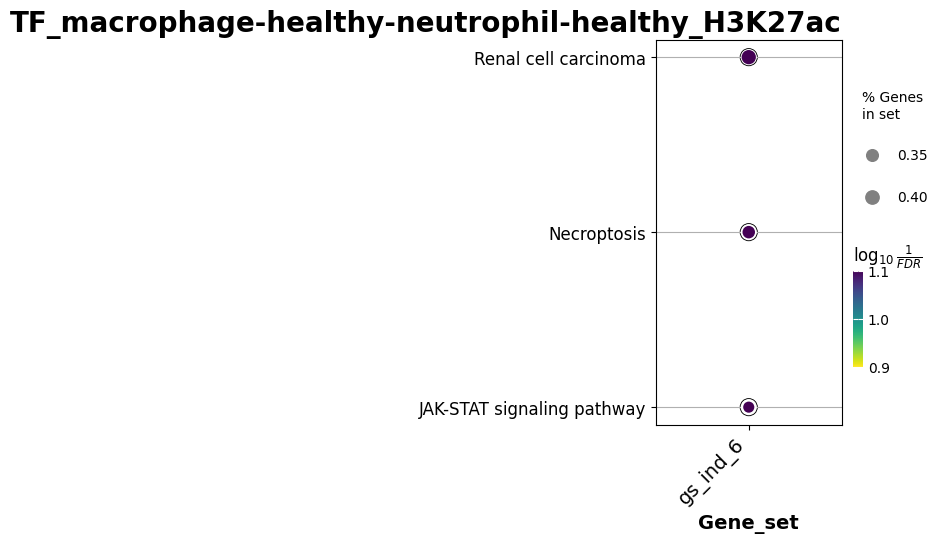

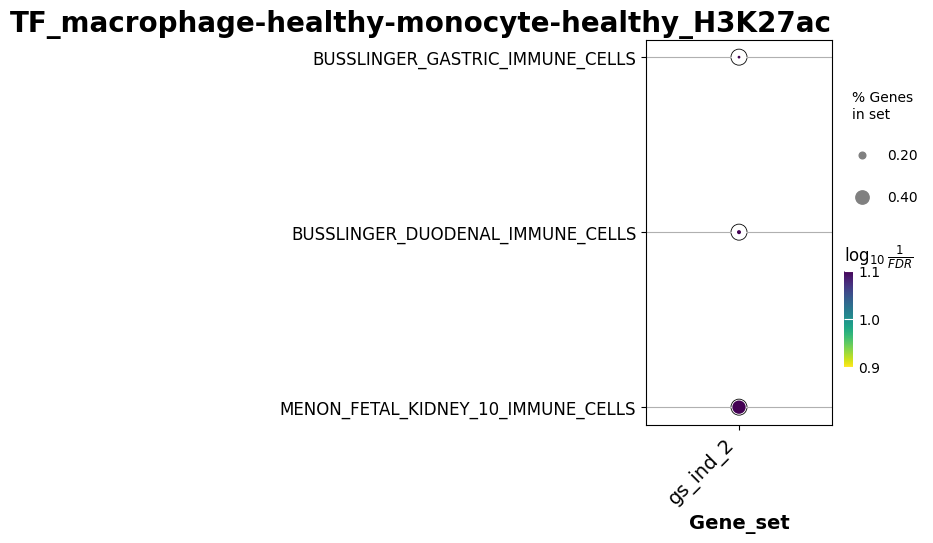

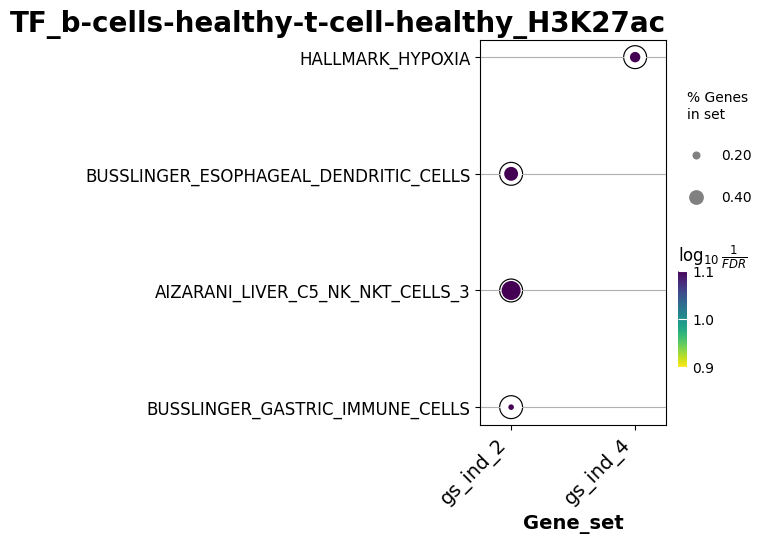

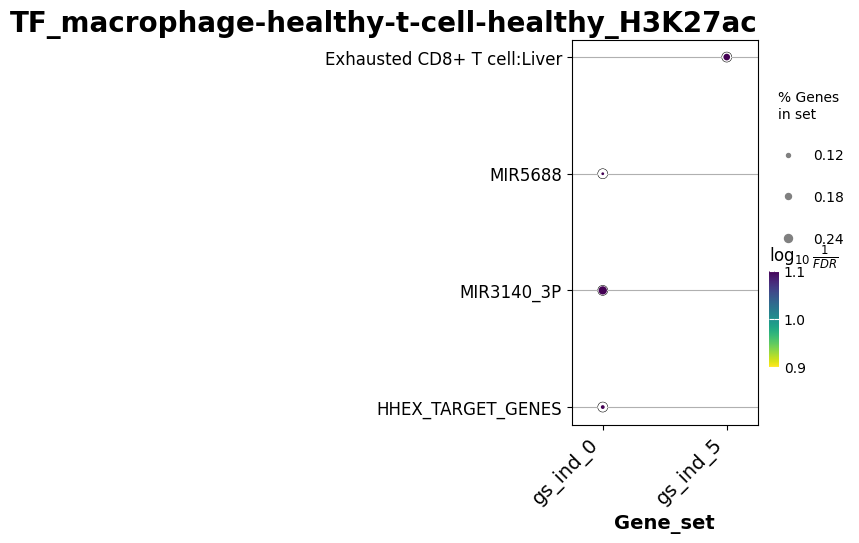

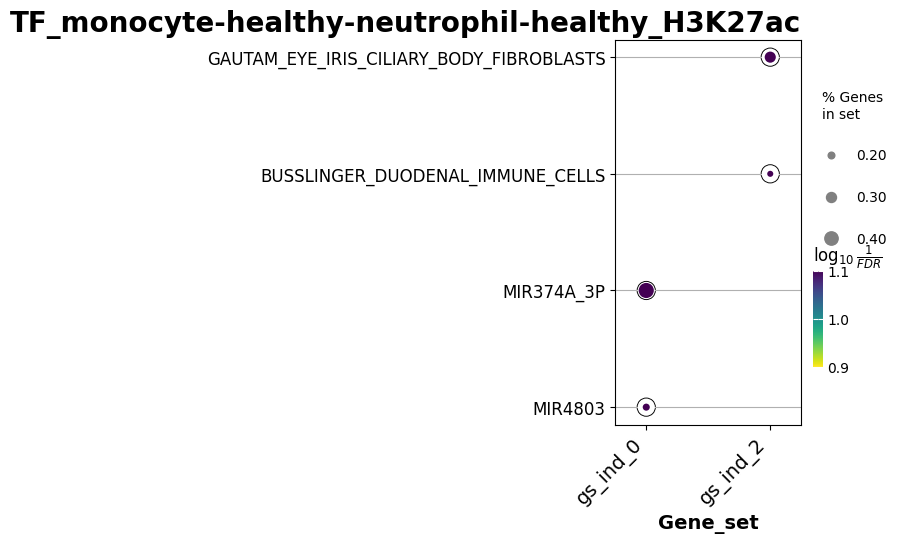

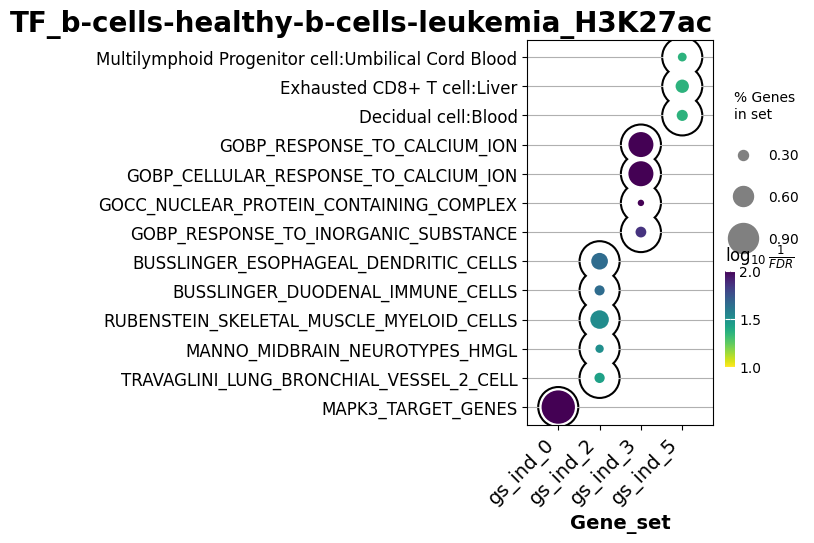

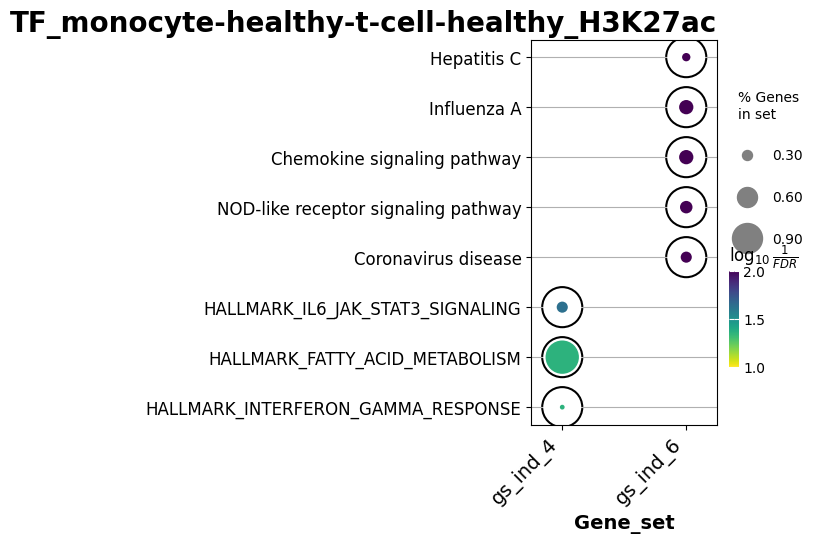

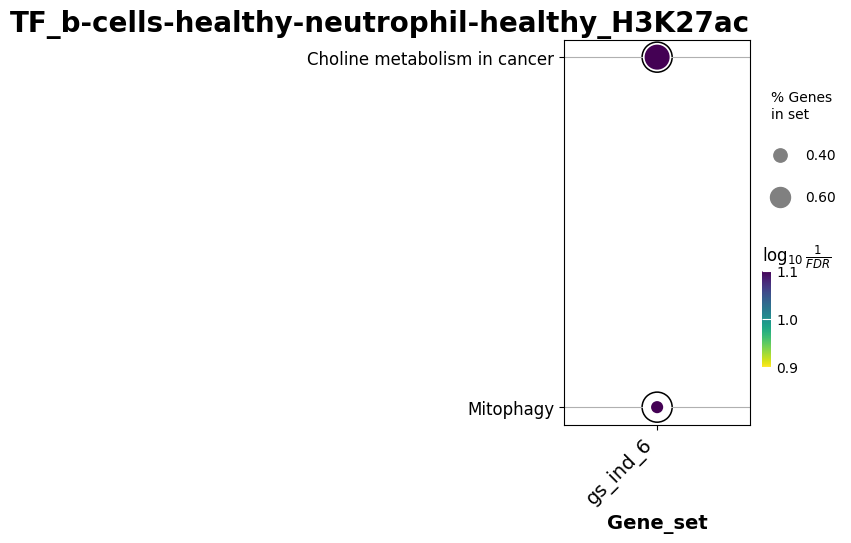

In [17]:
tf_results_dictionary = {}
for index, row in tf_hm_df_k27ac.iterrows():
    genes = list(myfunc.adjust_tfprio_used_TF(row["H3K27ac"]))
    try:
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=normal_gene_sets,
                    #organism='human', # organism argment is ignored because user input a background
                    background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                )
        ax = gp.dotplot(enr_bg.results,
                    column="Adjusted P-value",
                    x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                    size=4,
                    top_term=5,
                    figsize=(3,5),
                    xticklabels_rot=45, # rotate xtick labels
                    show_ring=True, # set to False to revmove outer ring
                    marker='o',
                    )
        y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
        ax.tick_params(axis='y', labelsize=y_axis_size)          
        ax.set_title("TF_"+index+"_H3K27ac", loc="right", fontsize=title_size,fontweight='bold')
        figure_file_name = "ORA_TF_"+index+"_H3Ka7ac"
        plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
        tf_results_dictionary[index] = enr_bg.results
    except ValueError as ve:
        print("For "+str(index)+"_H3K27ac")
        print(ve)

# GSEA on TFS
found nothing of interest; maybe macro-neutro GOPB_HEMOPOIESIS

In [ ]:
tf_score_hm_df = myfunc.read_out_top_tfs_per_hm_tpm_filter(path_to_main_comparison_dir, tpm_filter=1, modus="dataframe")
tf_score_hm_df_k27ac = tf_score_hm_df[["H3K27ac"]]


In [10]:
len(tf_score_hm_df["H3K27ac"][0])

21

2024-07-07 00:12:02,453 [INFO] Parsing data files for GSEA.............................
2024-07-07 00:12:02,728 [INFO] 21289 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-07-07 00:12:02,730 [INFO] 0053 gene_sets used for further statistical testing.....
2024-07-07 00:12:02,731 [INFO] Start to run GSEA...Might take a while..................
2024-07-07 00:12:02,784 [INFO] Congratulations. GSEApy runs successfully................

2024-07-07 00:12:02,942 [INFO] Parsing data files for GSEA.............................
2024-07-07 00:12:03,199 [INFO] 21329 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-07-07 00:12:03,201 [INFO] 0013 gene_sets used for further statistical testing.....
2024-07-07 00:12:03,202 [INFO] Start to run GSEA...Might take a while..................
2024-07-07 00:12:03,222 [INFO] Congratulations. GSEApy runs successfully................

2024-07-07 00:12:03,374 [INFO] Parsing data files for GSEA..........................

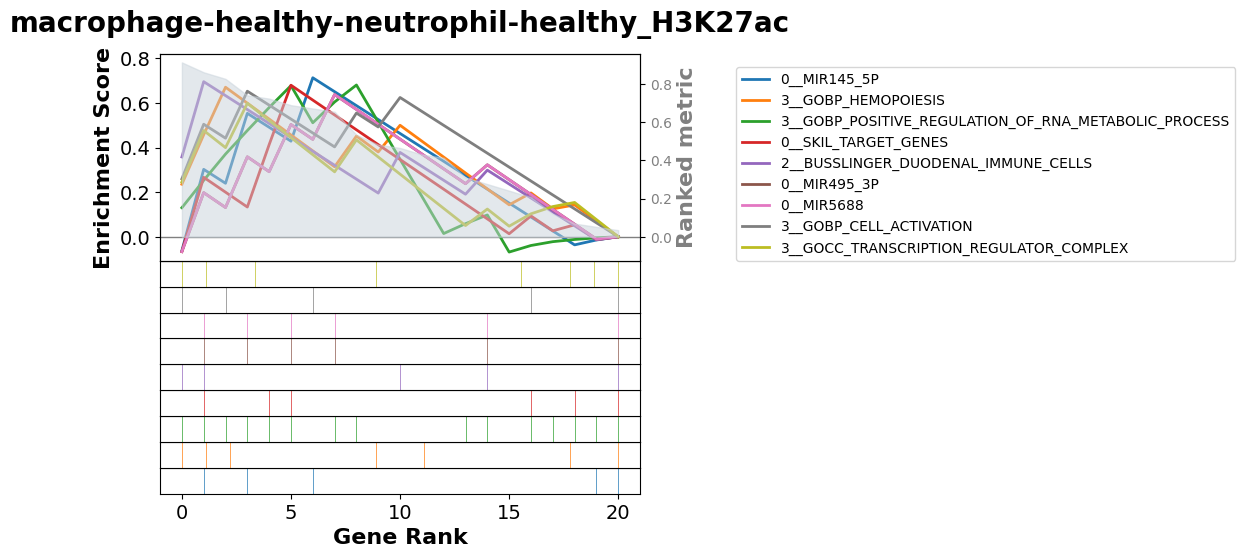

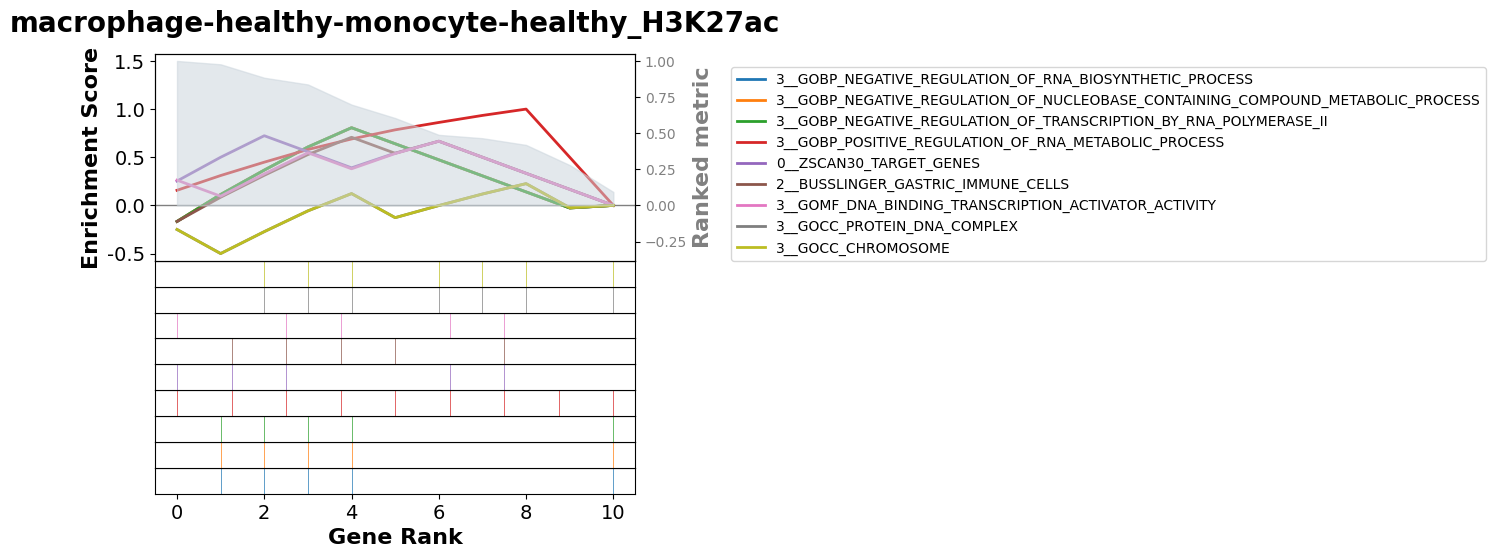

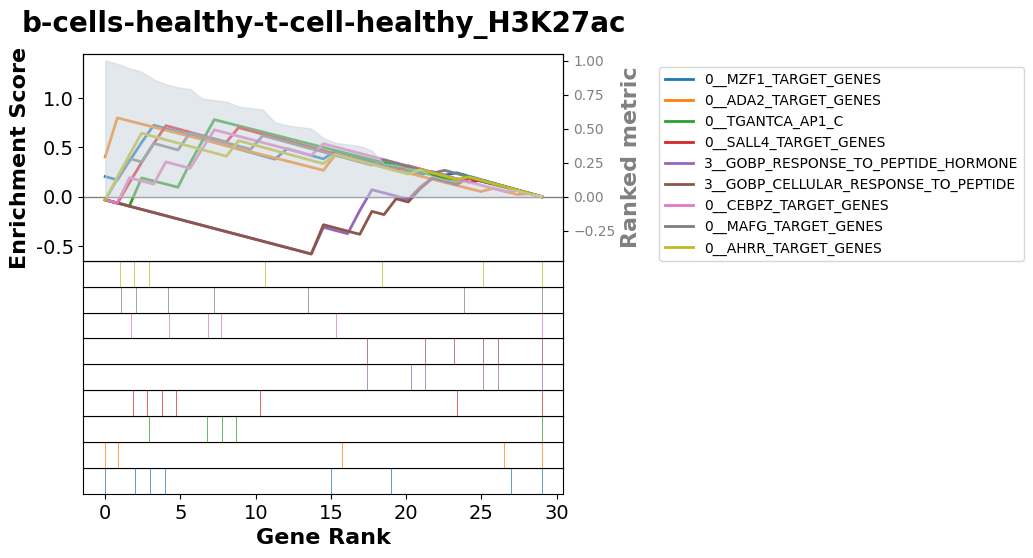

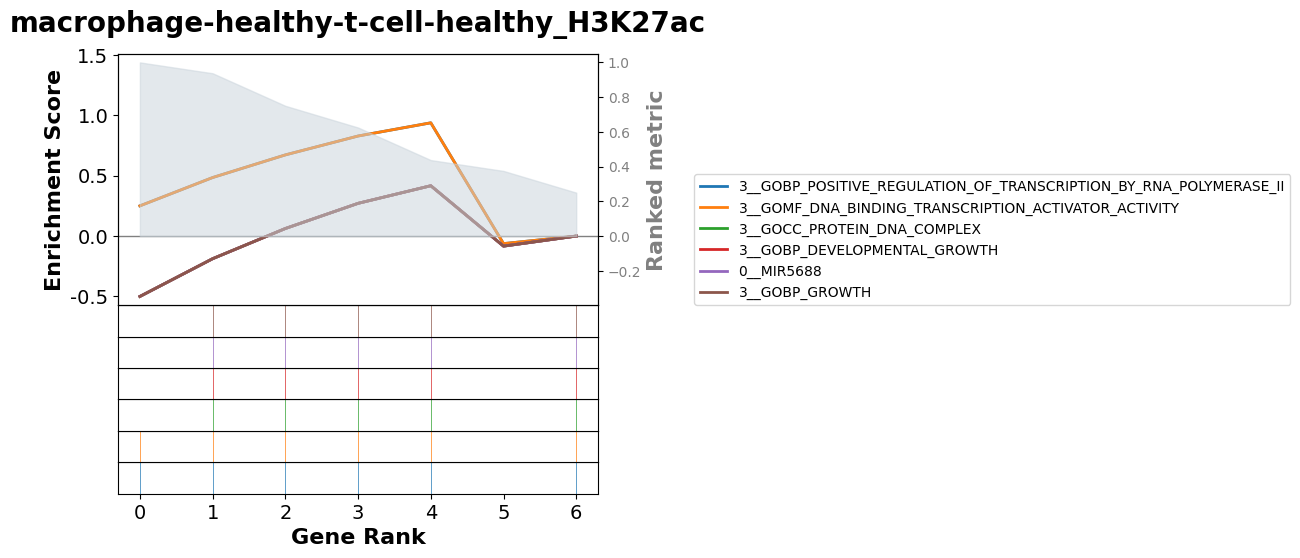

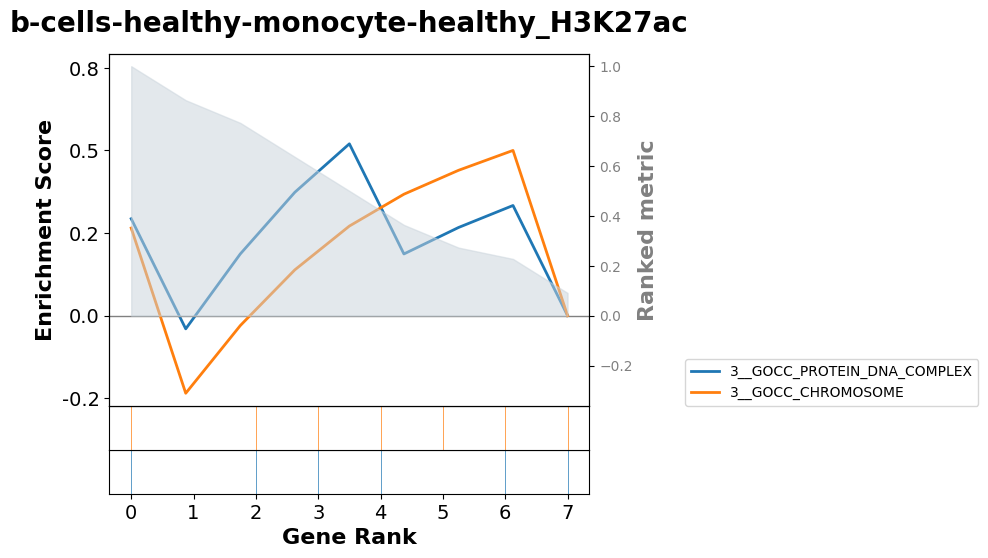

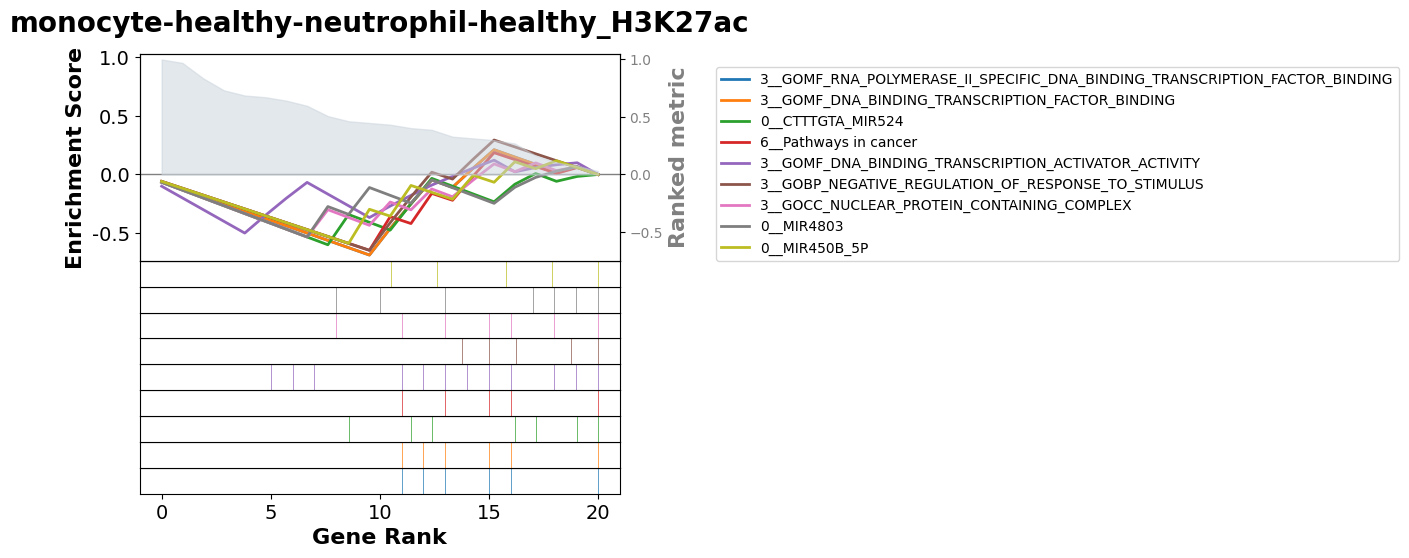

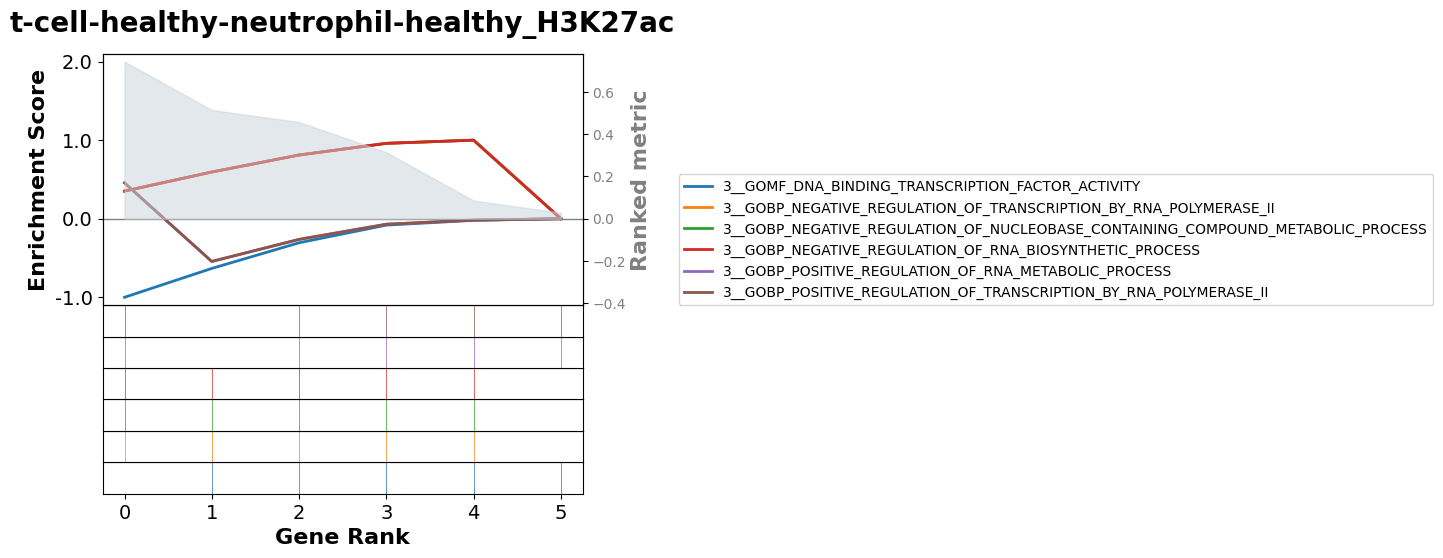

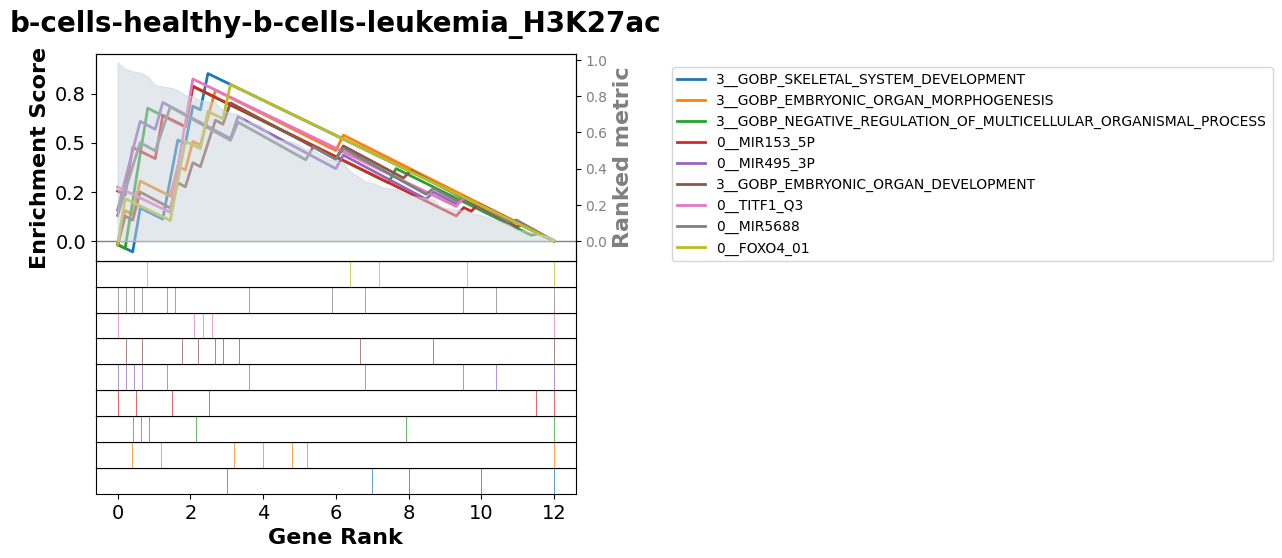

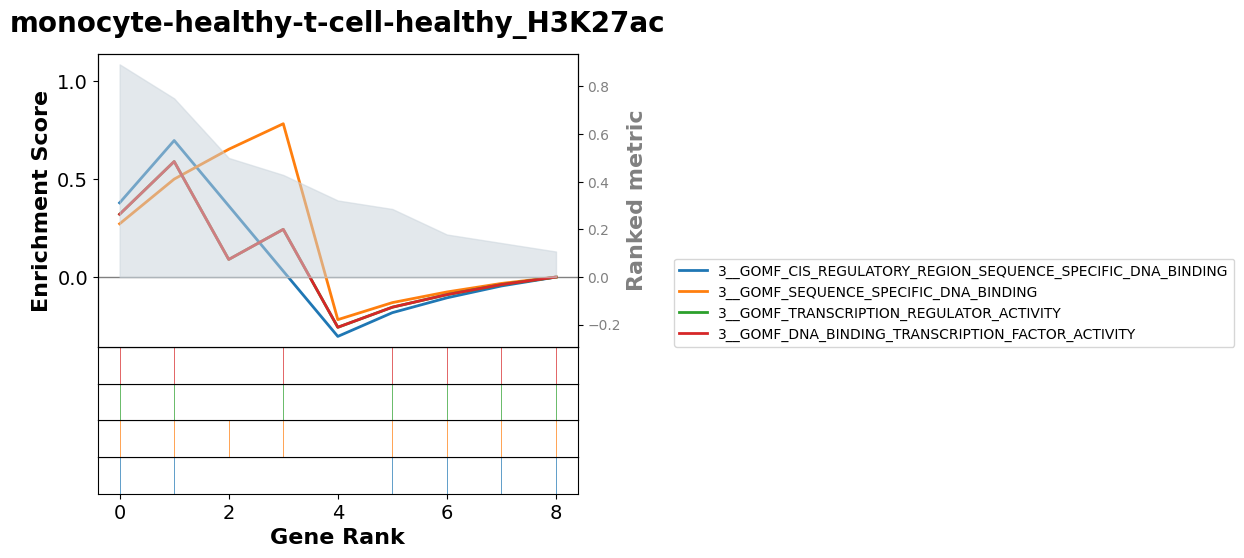

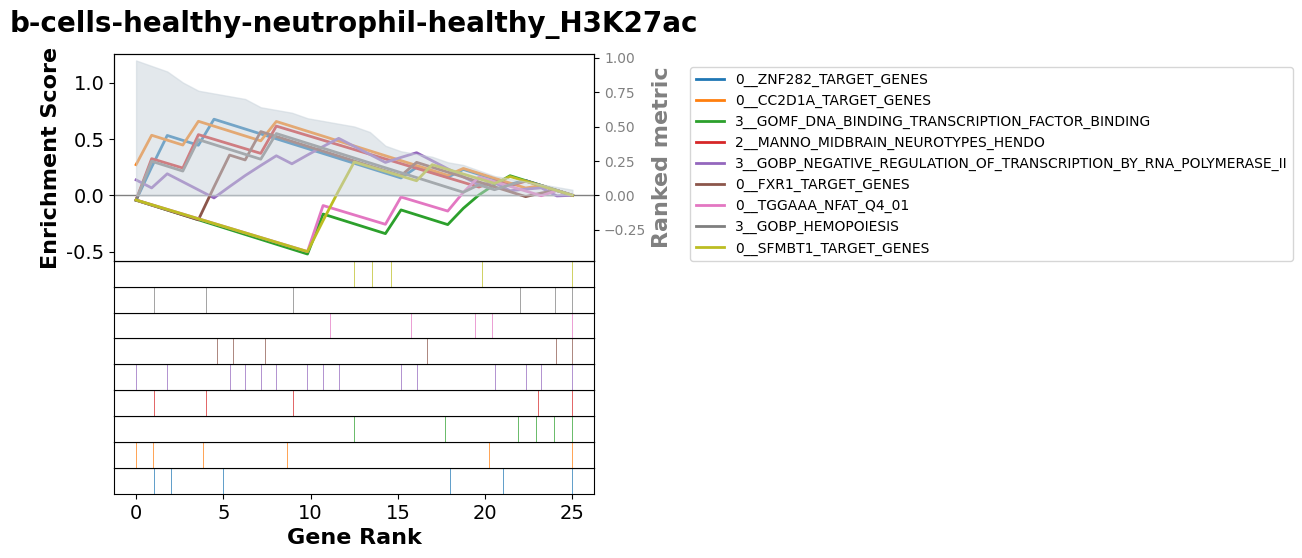

In [16]:
gsea_tf_results_dictionary = {}
for index, row in tf_score_hm_df_k27ac.iterrows():
    for hm in tf_score_hm_df_k27ac.columns:
        if len(row[hm]) > 1:
            scores_df = row[hm].rename(columns={'TF': '0', 'SCORE': '1'})
            try:
                pre_res = gp.prerank(rnk=scores_df, 
                            gene_sets=normal_gene_sets,
                            threads=4,
                            min_size=5,
                            max_size=1000,
                            permutation_num=2000, # reduce number to speed up testing
                            outdir=None, # don't write to disk
                            seed=6,
                            verbose=True, # see what's going on behind the scenes
                            )
            except LookupError as le:
                print("For "+str(index)+"_"+hm)
                print(le)

            try:
                terms = pre_res.res2d.Term
                axs = pre_res.plot(terms=terms[1:10],
                                legend_kws={'loc': (1.2, 0)}, # set the legend loc
                                show_ranking=True, # whether to show the second yaxis
                                figsize=(3,4)
                                )
                axs.suptitle(index+"_"+hm, fontsize=20, fontweight='bold')
                #ax.set_title(index+"_"+tf_type, loc="right", fontsize=20,fontweight='bold')
                figure_file_name = "GSEA_TF_H3K27ac_"+index+"_"+hm
                #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                gsea_tf_results_dictionary[index+"_"+hm] = pre_res
            except ValueError as ve:
                print("For "+str(index)+"_"+hm)
                print(ve)

# Unique TFs
does not make so much sense since there are no other marks used in this analysis.

In [60]:
tf_hm_df_k27ac = tf_hm_df_k27ac[["H3K27ac"]]

In [62]:
def find_unique_values(row):
        unique_values = []
        for value in row["H3K27ac"]:
            if all(value not in other_list for other_list in tf_hm_df_k27ac["H3K27ac"] if other_list != row["H3K27ac"]):
                unique_values.append(value)
        return set(unique_values)

tf_hm_df_k27ac["unique"] = tf_hm_df_k27ac.apply(find_unique_values, axis=1)

In [63]:
tf_hm_df_k27ac

H3K27ac  \
macrophage-healthy-neutrophil-healthy  {PRDM4, ZNF341, STAT2, ZKSCAN5, NEUROD2, ELK4,...   
macrophage-healthy-monocyte-healthy    {ELF5, PRDM4, ZNF341, MGA, MECP2, ZKSCAN5, KLF...   
b-cells-healthy-t-cell-healthy         {ZNF341, RUNX3, HIC2, TAL1::TCF3, FOXO3, KLF11...   
macrophage-healthy-t-cell-healthy        {ZBTB48, ZFX, STAT3, GATA3, ZNF384, KLF5, RBPJ}   
b-cells-healthy-monocyte-healthy       {ELF2, KLF9, NFYB, FOS::JUNB, NR2C1, ZNF331, B...   
monocyte-healthy-neutrophil-healthy    {NEUROD2, STAT3, E2F5, SREBF1, ELK4, FOSL1::JU...   
t-cell-healthy-neutrophil-healthy      {TCF7L2, ZBTB26, STAT1, ZNF263, FOXK2, CBFB, M...   
b-cells-healthy-b-cells-leukemia       {PRDM4, MEF2A, ZNF341, TAL1::TCF3, FOXO3, ZKSC...   
monocyte-healthy-t-cell-healthy        {TCF7L2, ELF5, ZKSCAN1, PPARA, ZNF784, RELA, M...   
b-cells-healthy-neutrophil-healthy     {ZKSCAN5, KLF3, ELK4, FOXM1, ELF5, ZNF317, ZBT...   

                                                                                  unique  
macrophage-healthy-neutrophil-healthy                {STAT2, ARNT, IKZF1, MSANTD3, ELF3}  
macrophage-healthy-monocyte-healthy               {TBP, CTCFL, NFATC3, GSC2, EBF3, KLF6}  
b-cells-healthy-t-cell-healthy         {RUNX3, HIC2, ETS1, CREB1, STAT5A, FOSL2, FOXJ...  
macrophage-healthy-t-cell-healthy                                                     {}  
b-cells-healthy-monocyte-healthy                       {ELF2, NFYB, ZNF331, BATF3, EBF1}  
monocyte-healthy-neutrophil-healthy    {TWIST1, NFE2L2, E2F5, SREBF1, PATZ1, JUND, TF...  
t-cell-healthy-neutrophil-healthy                                                {STAT1}  
b-cells-healthy-b-cells-leukemia       {MEF2A, MXI1, FOS::JUN, GFI1B, TCF12, MNT, SP2...  
monocyte-healthy-t-cell-healthy            {ZKSCAN1, ZNF784, MBD2, ZNF449, STAT1::STAT2}  
b-cells-healthy-neutrophil-healthy                            {ZNF317, MAZ, KLF3, CEBPG}

# ORA on TGs

reading in the gtf dictionary, based on the gtf file, that is used for the conversion of ensg symbols to hgnc symbols

In [10]:
gtf_dict = myfunc.read_gtf_and_create_ensg_hgnc_dict()

creating dataframes with either top K TGs for every TF or all TGs for every TF (above the affinity threshold)

In [11]:
df_k27ac_top_k_tg = myfunc.read_out_filtered_target_genes_df(tf_hm_df_k27ac, path_to_main_comparison_dir, tf_per_hm=True)
df_k27ac_all_tg = myfunc.read_out_filtered_target_genes_df(tf_hm_df_k27ac, path_to_main_comparison_dir, modus = "all_genes", tf_per_hm=True)


converting the ENSG gene sets to HGNC gene sets

In [12]:
df_k27ac_top_k_tg_hgnc = df_k27ac_top_k_tg.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
df_k27ac_all_tgs_hgnc = df_k27ac_all_tg.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))

showing the resulting numbers of the dataframes

In [13]:
df_k27ac_top_k_tg_hgnc.applymap(lambda x: len(set(x)))

H3K27ac
b-cells-healthy-b-cells-leukemia             8
b-cells-healthy-monocyte-healthy             0
b-cells-healthy-neutrophil-healthy           4
b-cells-healthy-t-cell-healthy             122
macrophage-healthy-monocyte-healthy         55
macrophage-healthy-neutrophil-healthy        6
macrophage-healthy-t-cell-healthy           62
monocyte-healthy-neutrophil-healthy         76
monocyte-healthy-t-cell-healthy              0
t-cell-healthy-neutrophil-healthy            1

In [14]:
df_k27ac_all_tgs_hgnc.applymap(lambda x: len(set(x)))

H3K27ac
b-cells-healthy-b-cells-leukemia             8
b-cells-healthy-monocyte-healthy             0
b-cells-healthy-neutrophil-healthy           4
b-cells-healthy-t-cell-healthy           19222
macrophage-healthy-monocyte-healthy        754
macrophage-healthy-neutrophil-healthy        6
macrophage-healthy-t-cell-healthy        17792
monocyte-healthy-neutrophil-healthy        153
monocyte-healthy-t-cell-healthy              0
t-cell-healthy-neutrophil-healthy            1

## healthy cells

### top k target genes (nothing interesting found)

In [16]:
df_k27ac_healthy_cell_type_top_k_tg = df_k27ac_top_k_tg_hgnc.drop(["b-cells-healthy-b-cells-leukemia"])


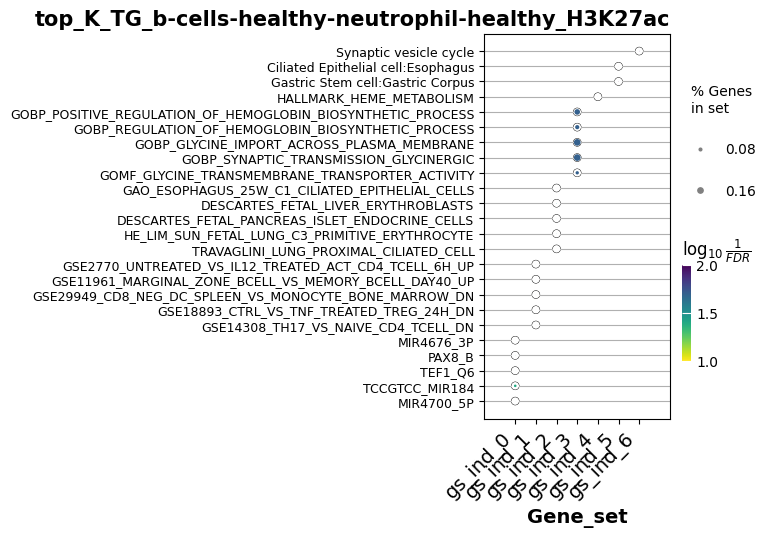

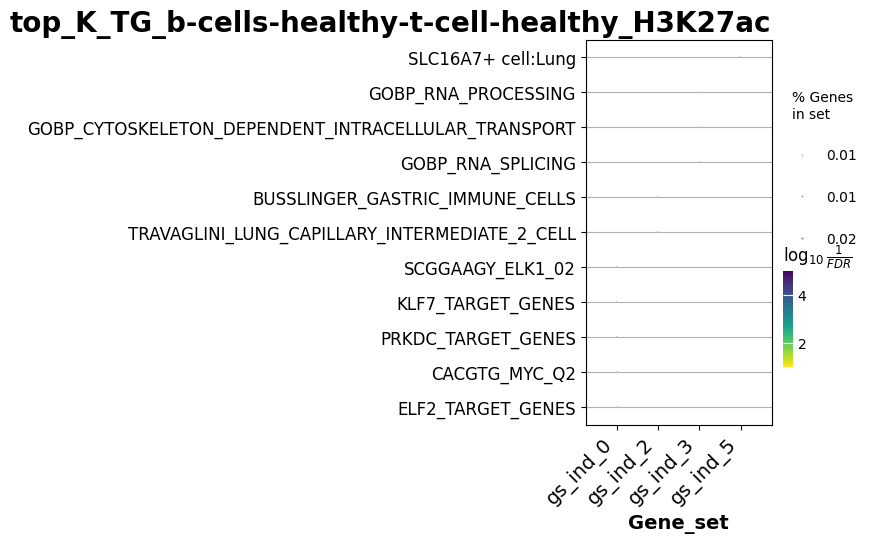

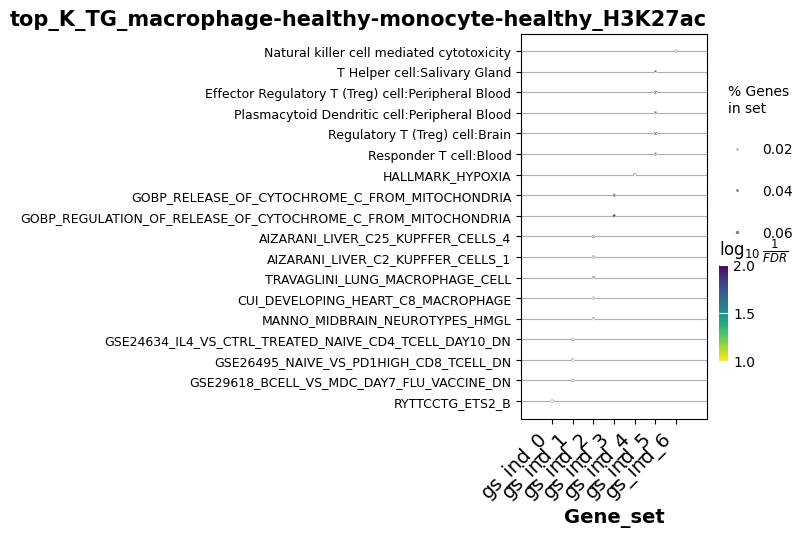

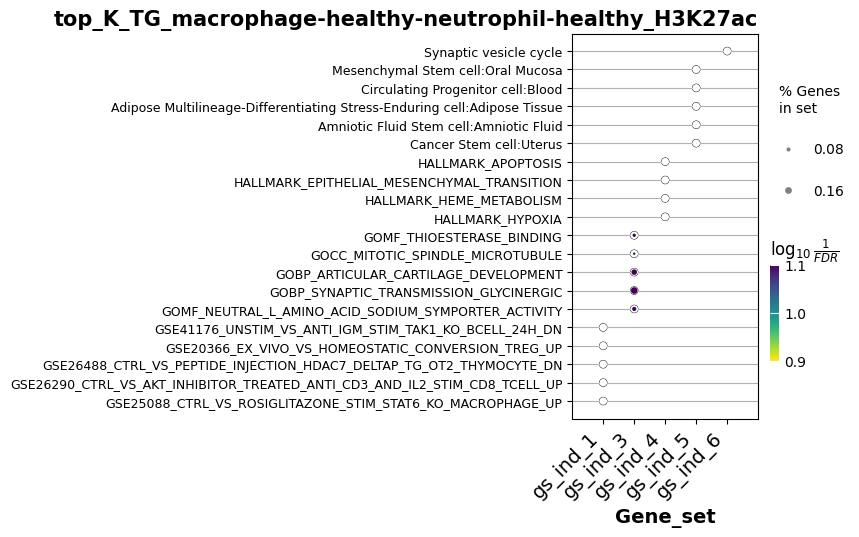

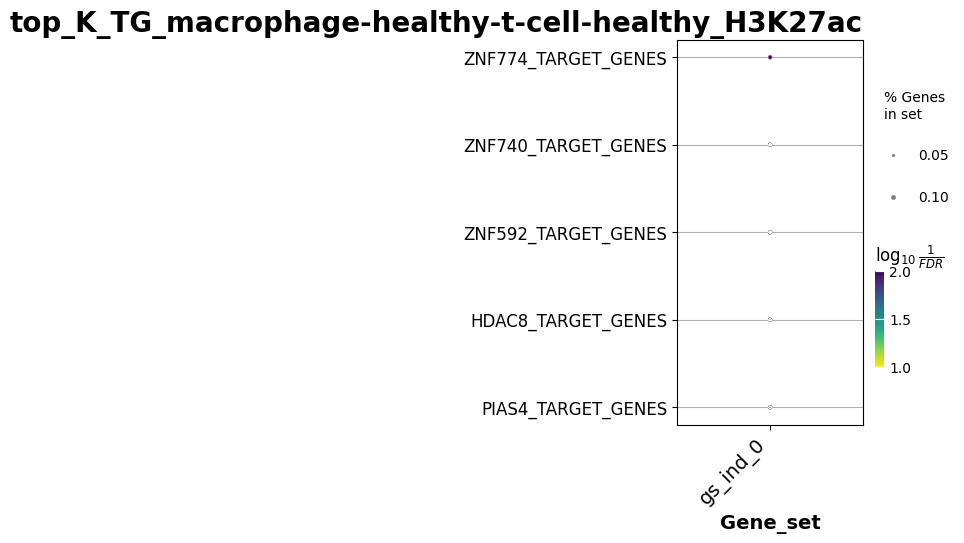

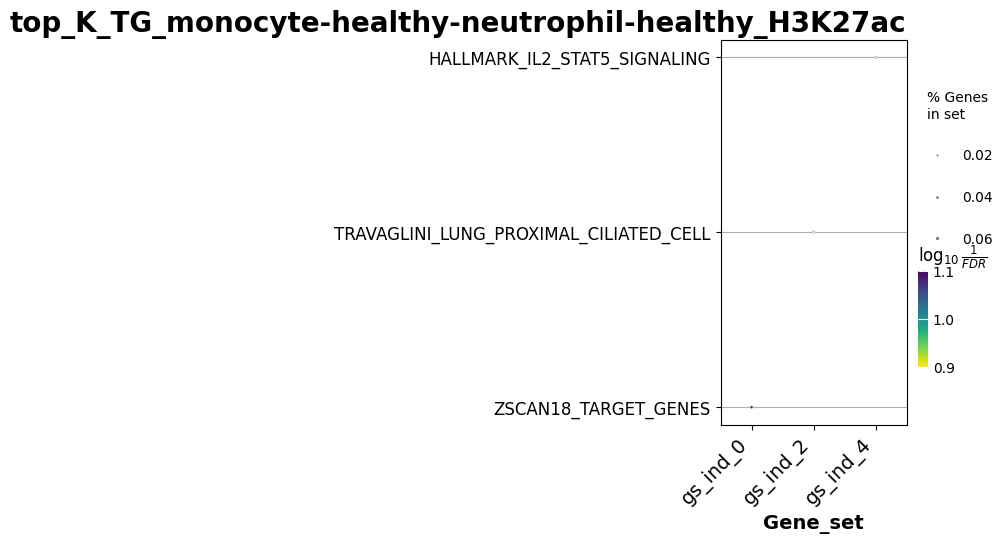

In [22]:
top_k_tg_results_dictionary = {}
for index, row in df_k27ac_healthy_cell_type_top_k_tg.iterrows():
    for hm in df_k27ac_healthy_cell_type_top_k_tg.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        if len(genes) > 1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', 
                        #background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("top_K_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_top_k_TG_"+index+"_"+hm
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                top_k_tg_results_dictionary[index+"_"+hm] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+hm)
                print(ve)

### all target genes (nothing interesting found)

In [23]:
df_k27ac_healthy_cell_type_all_tg = df_k27ac_all_tgs_hgnc.drop(["b-cells-healthy-b-cells-leukemia"])


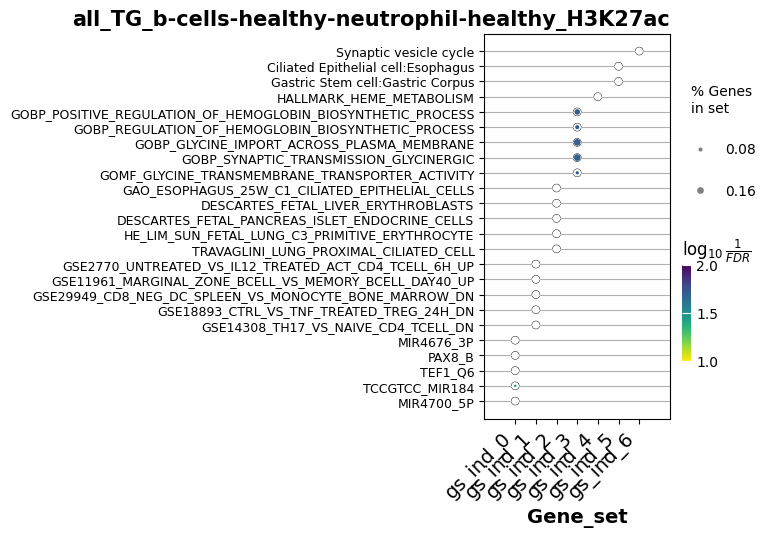

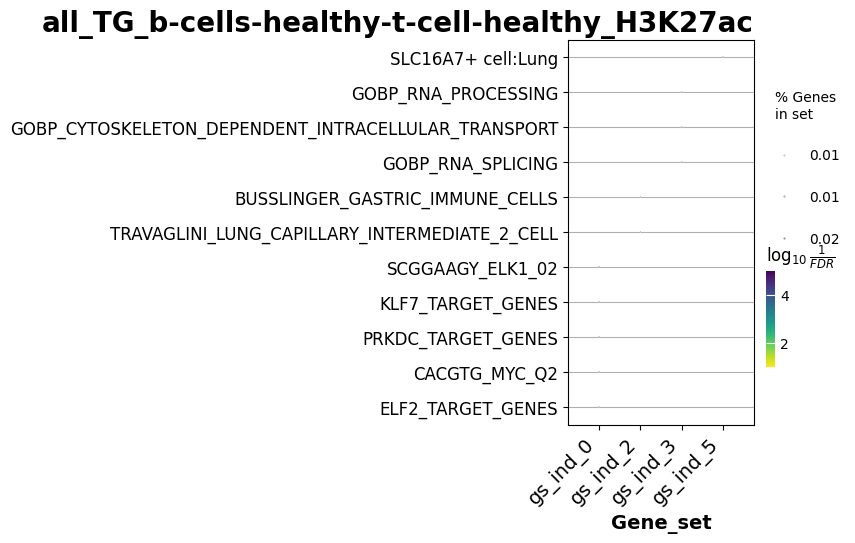

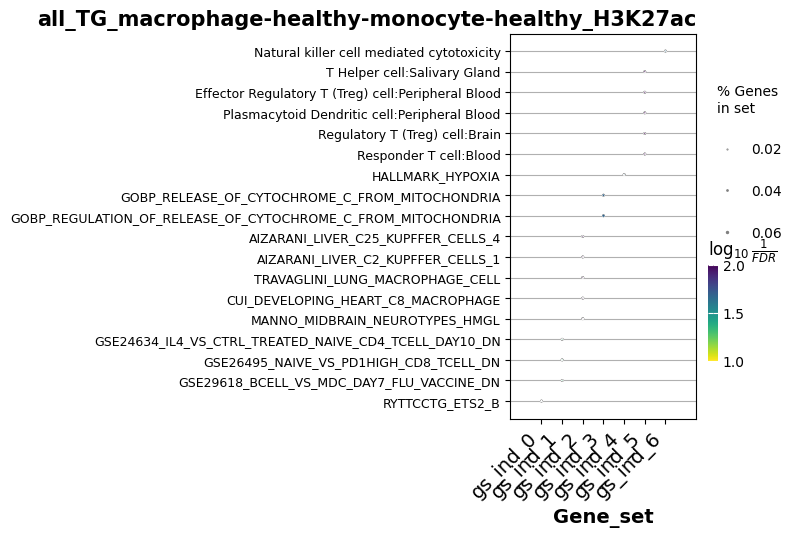

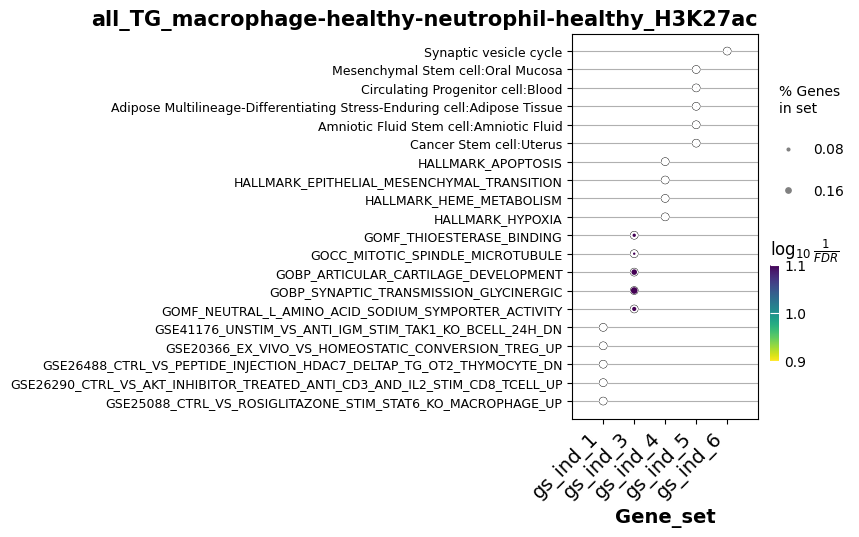

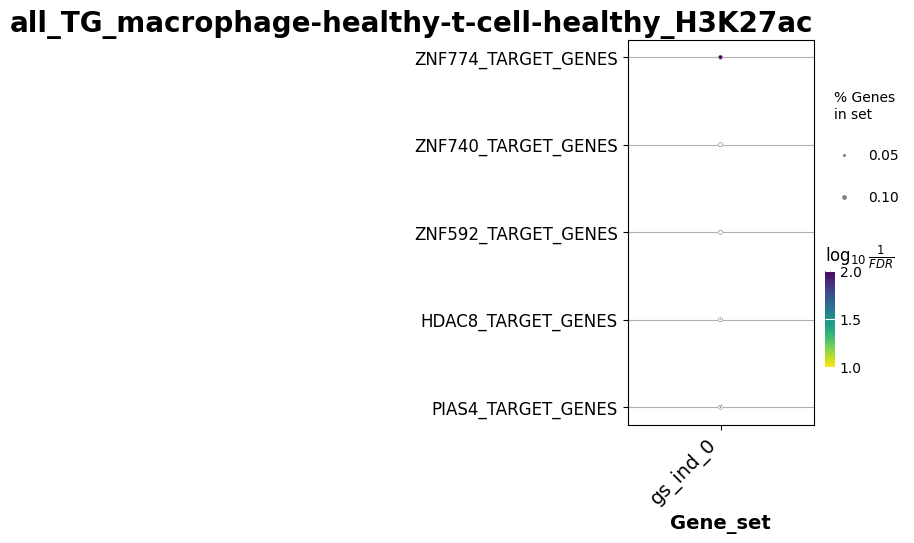

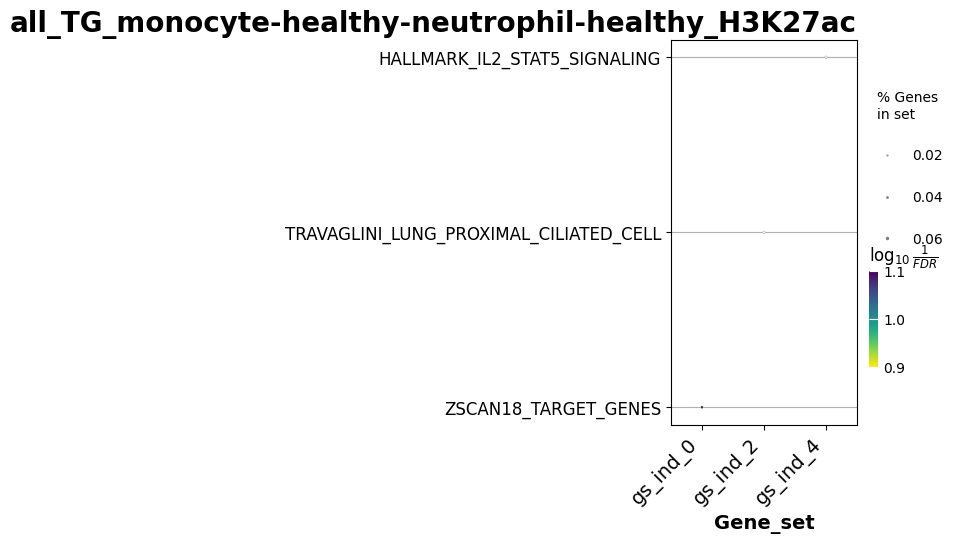

In [24]:
all_tg_results_dictionary = {}
for index, row in df_k27ac_healthy_cell_type_top_k_tg.iterrows():
    for hm in df_k27ac_healthy_cell_type_top_k_tg.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        if len(genes) > 1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', 
                        #background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("all_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_all_TG_"+index+"_"+hm
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                all_tg_results_dictionary[index+"_"+hm] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+hm)
                print(ve)

## leukemia

-> no differences in set sizes for all TGs or top k TGs; ORA plots are therefore identical

### top k target genes (nothing interesting found)

In [31]:
df_leukemia_top_k_tgs = df_k27ac_top_k_tg_hgnc.loc[["b-cells-healthy-b-cells-leukemia"]]

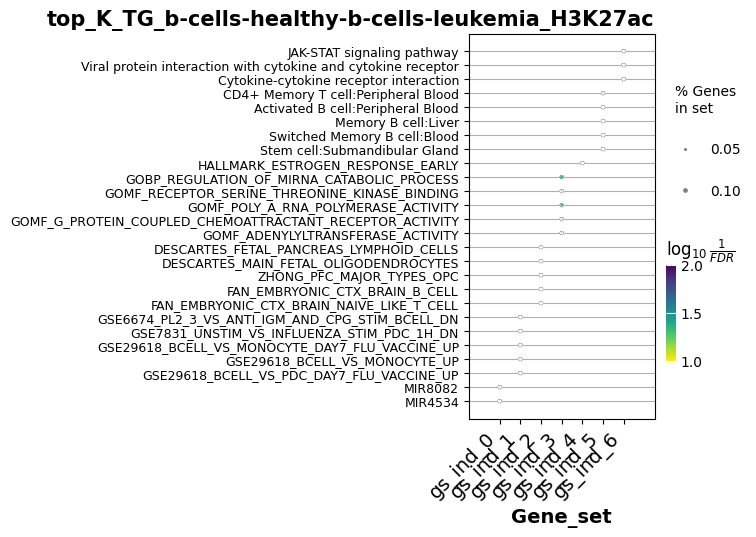

In [26]:
top_k_tg_leukemia_results_dictionary = {}
for index, row in df_leukemia_top_k_tgs.iterrows():
    for hm in df_leukemia_top_k_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=normal_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        #title = index+"_"+tf_type,
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("top_K_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_top_k_TG_"+index+"_"+hm
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            top_k_tg_leukemia_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

### all target genes (nothing interesting found)

In [27]:
df_leukemia_all_tgs = df_k27ac_all_tgs_hgnc.loc[["b-cells-healthy-b-cells-leukemia"]]

In [33]:
df_leukemia_all_tgs.applymap(lambda x: len(x))

H3K27ac
b-cells-healthy-b-cells-leukemia        8

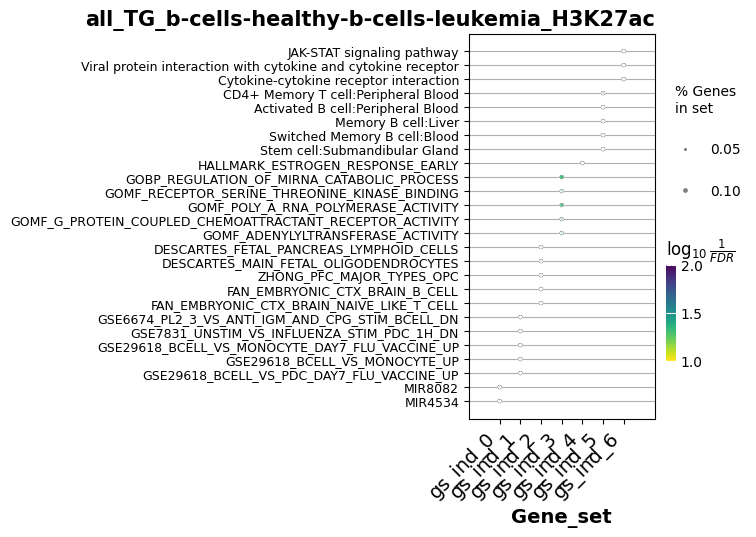

In [29]:
all_tg_leukemia_results_dictionary = {}
for index, row in df_leukemia_all_tgs.iterrows():
    for hm in df_leukemia_all_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        #print(genes)
        #print(genes)
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=normal_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("all_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_all_TG_"+index+"_"+hm
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            all_tg_leukemia_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

# ORA TF + TG

creating the merged dataframes for either top K TGs or all TGs

In [34]:
df_k27ac_tf_top_k_tg_hgnc = pd.DataFrame(index=tf_hm_df_k27ac.index, columns=tf_hm_df_k27ac.columns)
df_k27ac_tf_all_tgs_hgnc = pd.DataFrame(index=tf_hm_df_k27ac.index, columns=tf_hm_df_k27ac.columns)
for row in tf_hm_df_k27ac.index:
    for col in tf_hm_df_k27ac.columns:
        df_k27ac_tf_top_k_tg_hgnc.at[row, col] = tf_hm_df_k27ac.at[row, col].union(df_k27ac_top_k_tg_hgnc.at[row, col])
        df_k27ac_tf_all_tgs_hgnc.at[row, col] = tf_hm_df_k27ac.at[row, col].union(df_k27ac_all_tgs_hgnc.at[row, col])

Displaying the sizes of the merged dataframes

In [35]:
df_k27ac_tf_top_k_tg_hgnc.applymap(lambda x: len(set(x)))

H3K27ac
macrophage-healthy-neutrophil-healthy       34
macrophage-healthy-monocyte-healthy         73
b-cells-healthy-t-cell-healthy             164
macrophage-healthy-t-cell-healthy           69
b-cells-healthy-monocyte-healthy            10
monocyte-healthy-neutrophil-healthy        108
t-cell-healthy-neutrophil-healthy            9
b-cells-healthy-b-cells-leukemia            74
monocyte-healthy-t-cell-healthy             11
b-cells-healthy-neutrophil-healthy          35

In [36]:
df_k27ac_tf_all_tgs_hgnc.applymap(lambda x: len(set(x)))

H3K27ac
macrophage-healthy-neutrophil-healthy       34
macrophage-healthy-monocyte-healthy        771
b-cells-healthy-t-cell-healthy           19243
macrophage-healthy-t-cell-healthy        17795
b-cells-healthy-monocyte-healthy            10
monocyte-healthy-neutrophil-healthy        185
t-cell-healthy-neutrophil-healthy            9
b-cells-healthy-b-cells-leukemia            74
monocyte-healthy-t-cell-healthy             11
b-cells-healthy-neutrophil-healthy          35

## healthy cells

###  top k target genes (nothing interesting found)

In [37]:
healthy_cells_tf_top_k_tg_df = df_k27ac_tf_top_k_tg_hgnc.drop(["b-cells-healthy-b-cells-leukemia"])

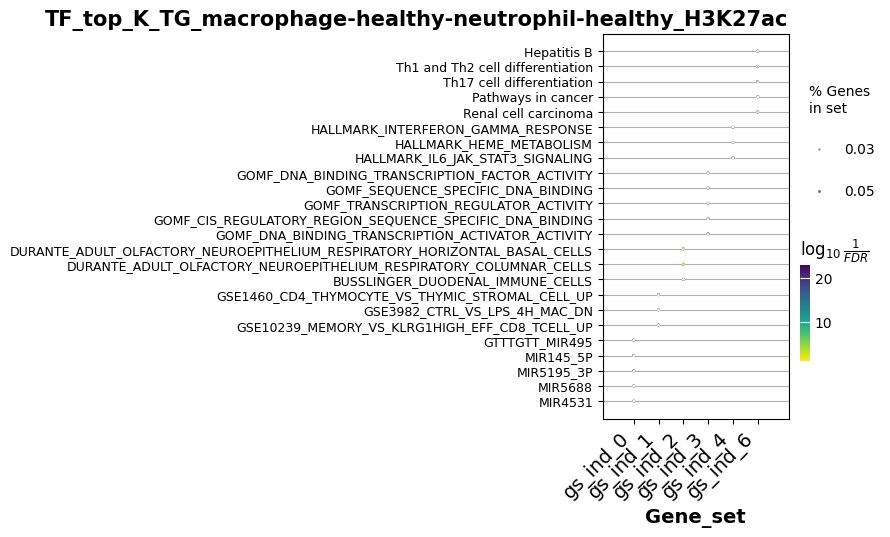

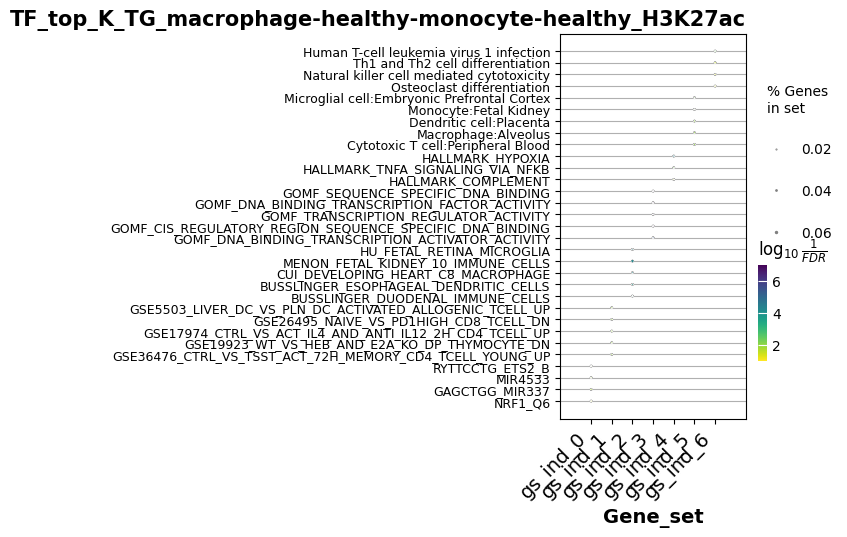

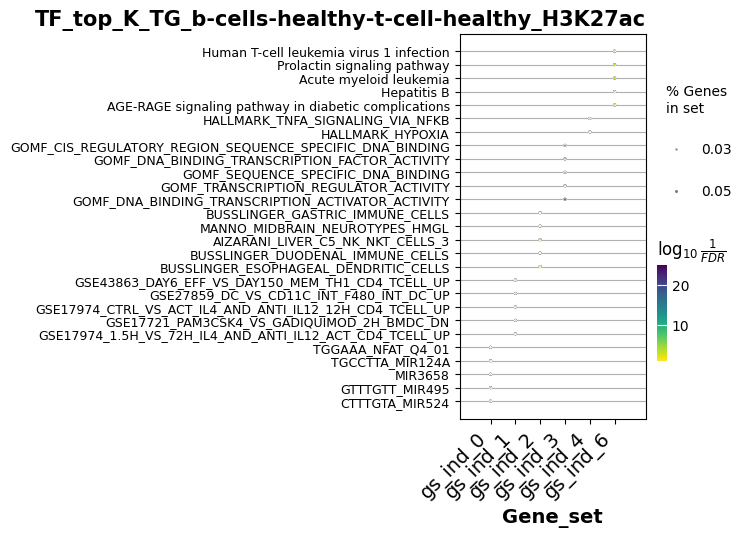

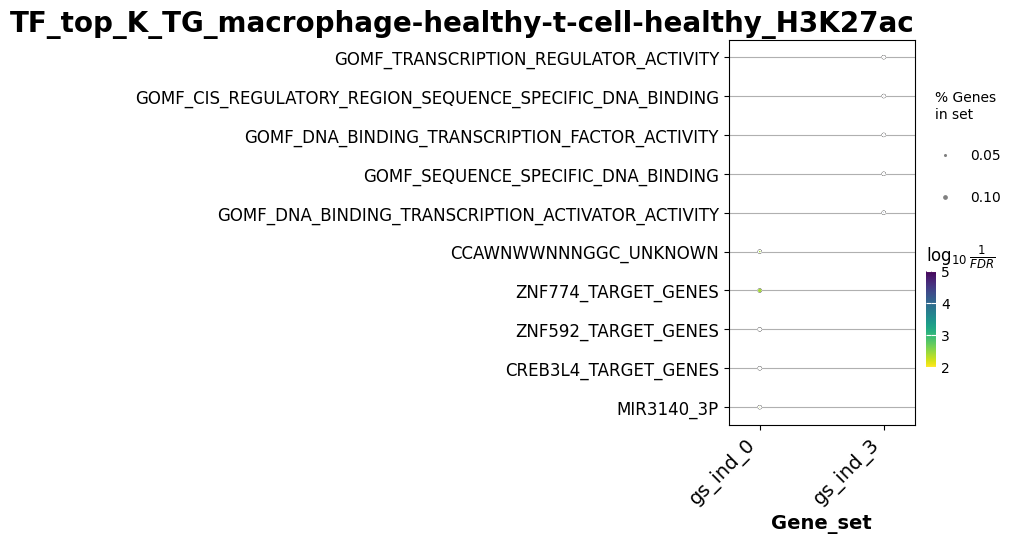

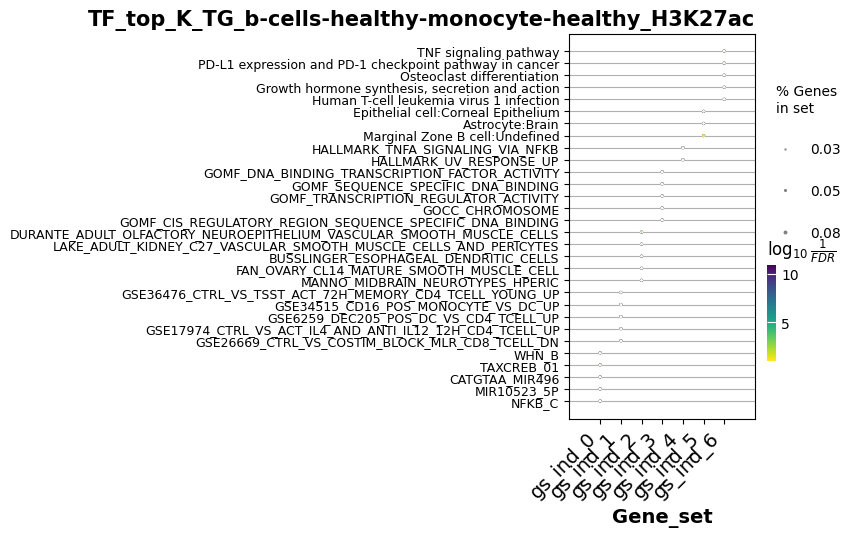

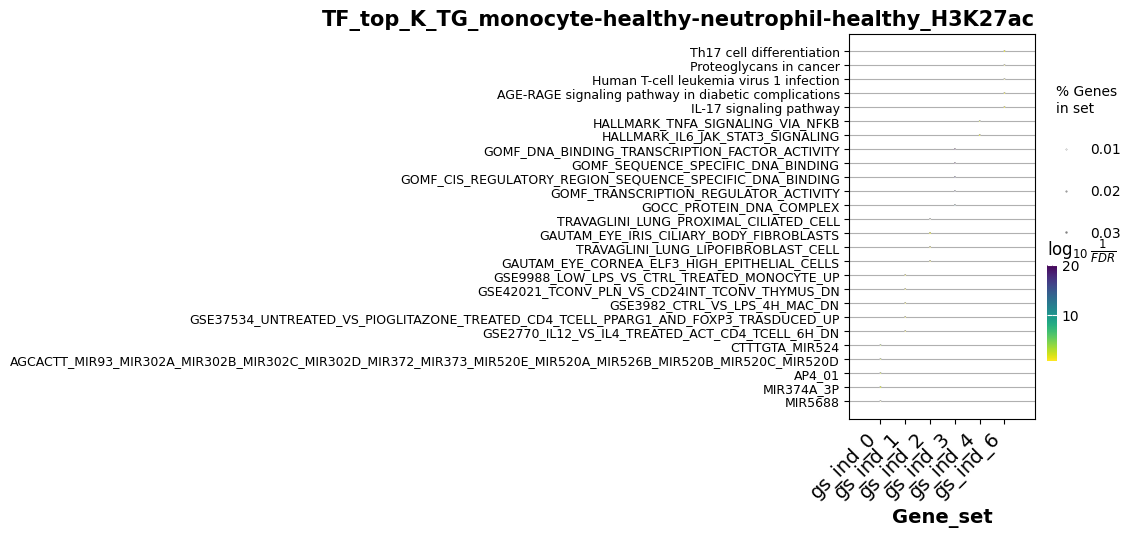

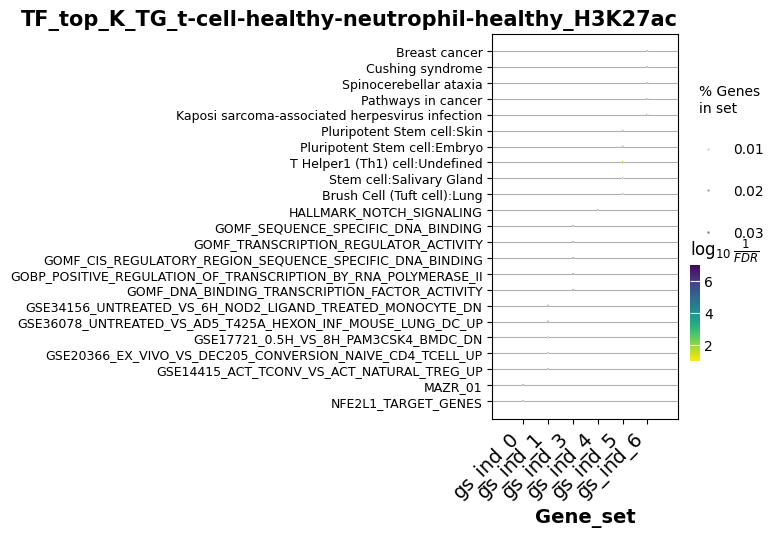

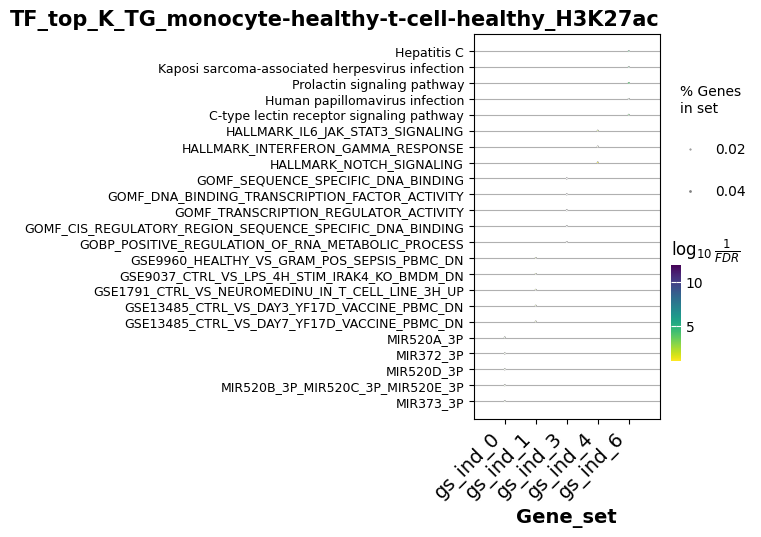

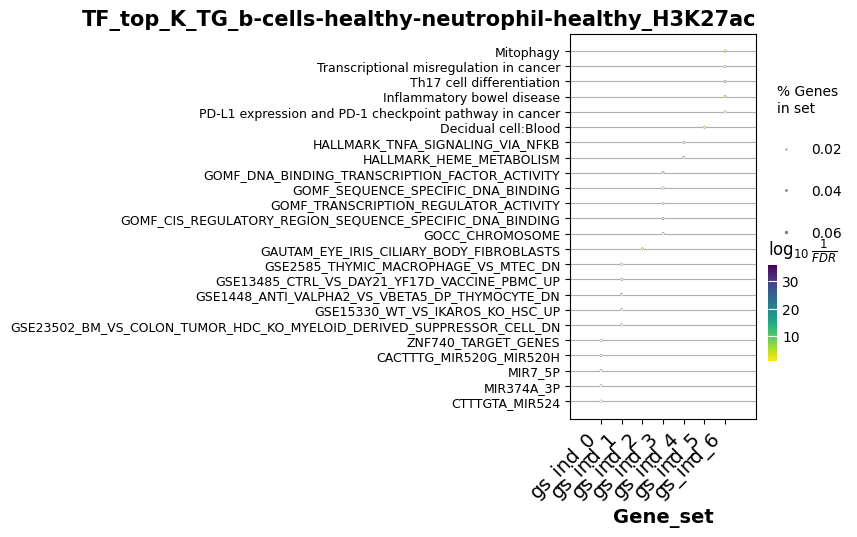

In [42]:
healthy_cells_tf_top_k_tg_results_dictionary = {}
for index, row in healthy_cells_tf_top_k_tg_df.iterrows():
    for hm in healthy_cells_tf_top_k_tg_df.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        if len(genes) > 1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        #background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("TF_top_K_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_TF_top_k_TG_"+index+"_"+hm
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                healthy_cells_tf_top_k_tg_results_dictionary[index+"_"+hm] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+hm)
                print(ve)

### all target genes (nothing interesting found)

In [40]:
healthy_cells_tf_all_tg_df = df_k27ac_tf_all_tgs_hgnc.drop(["b-cells-healthy-b-cells-leukemia"])

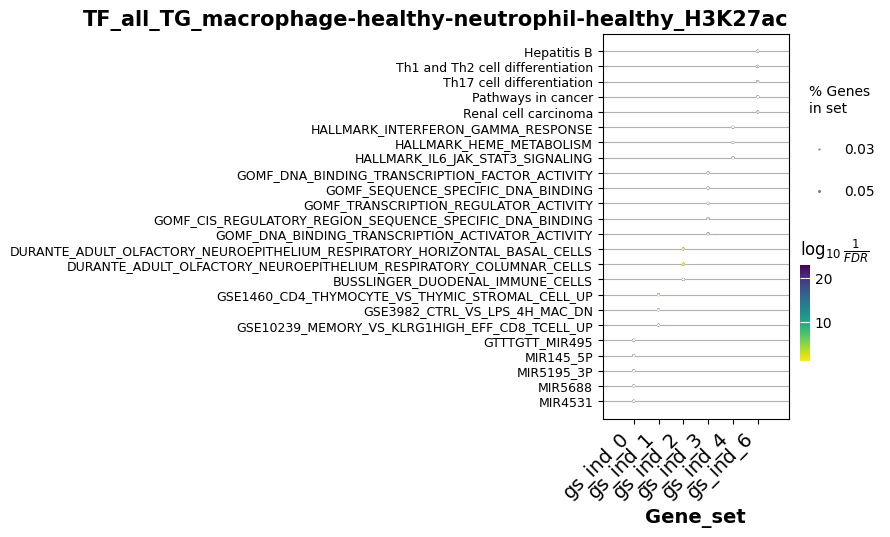

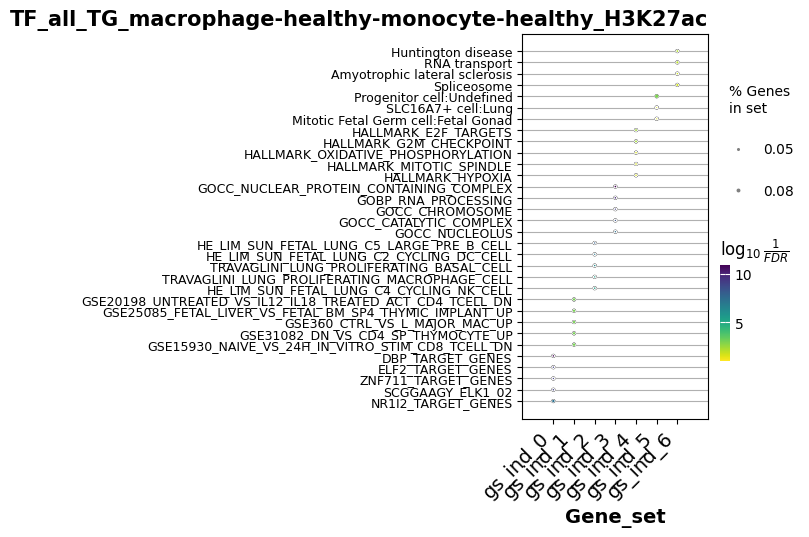

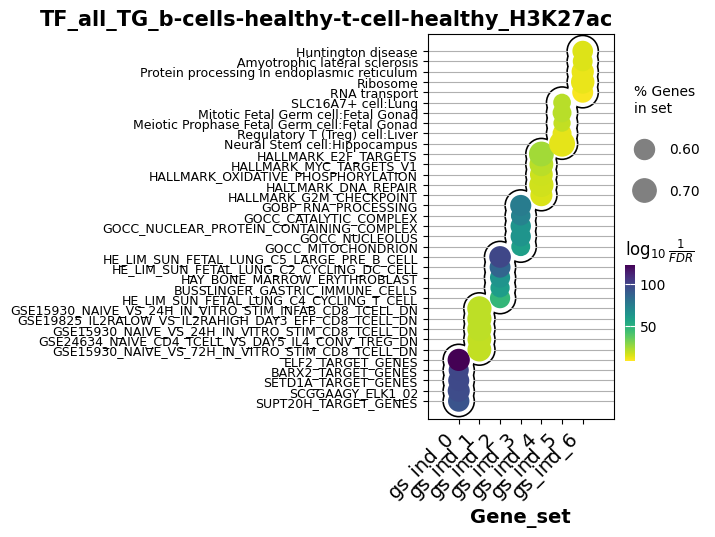

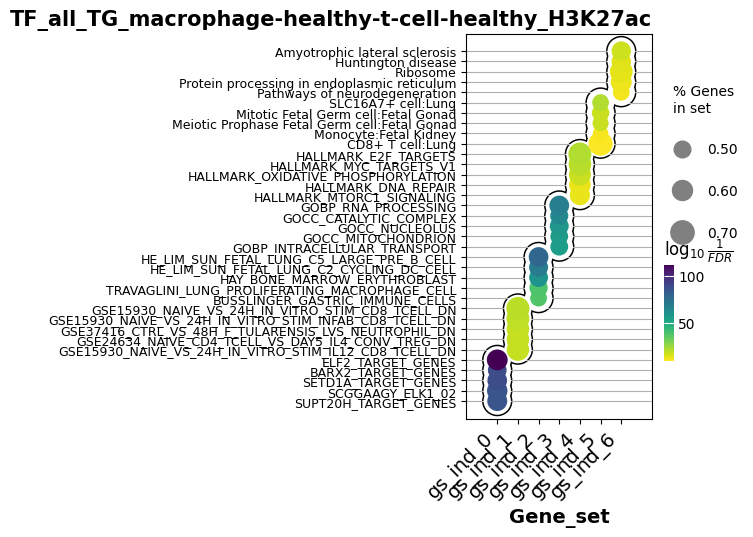

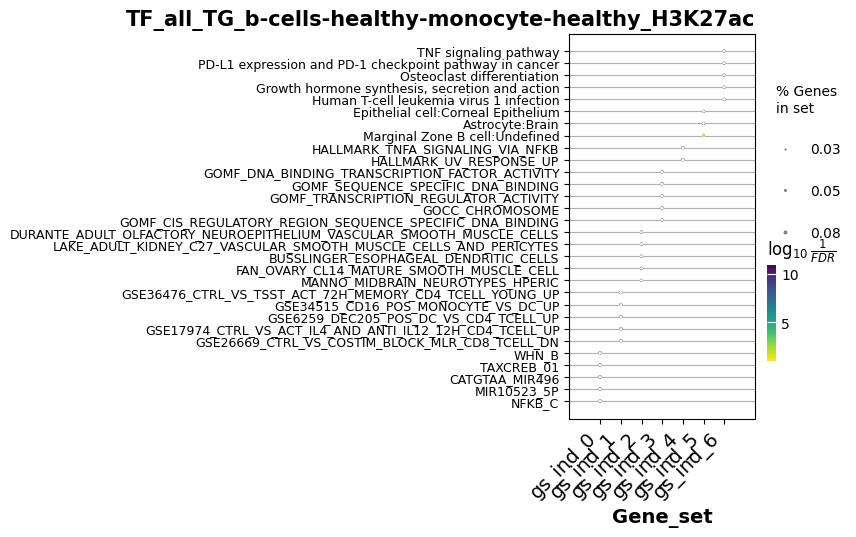

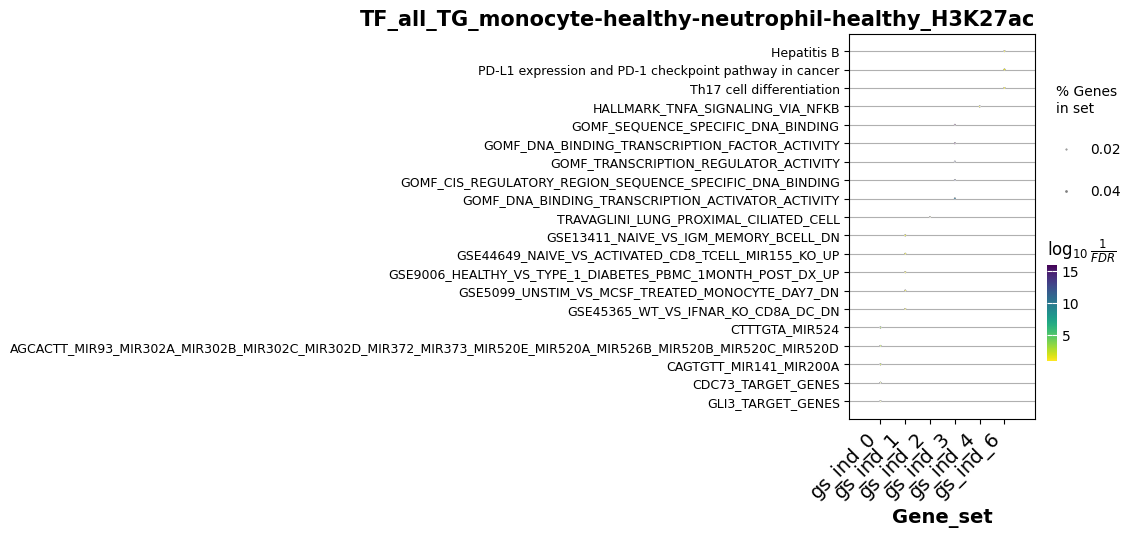

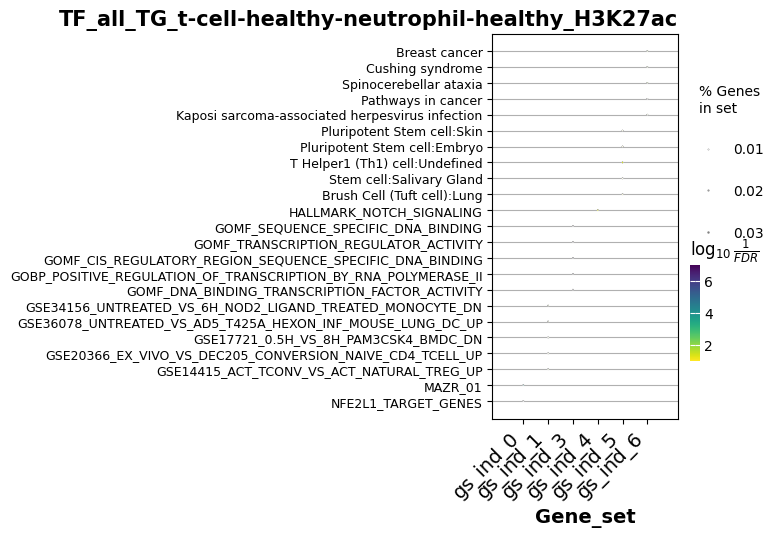

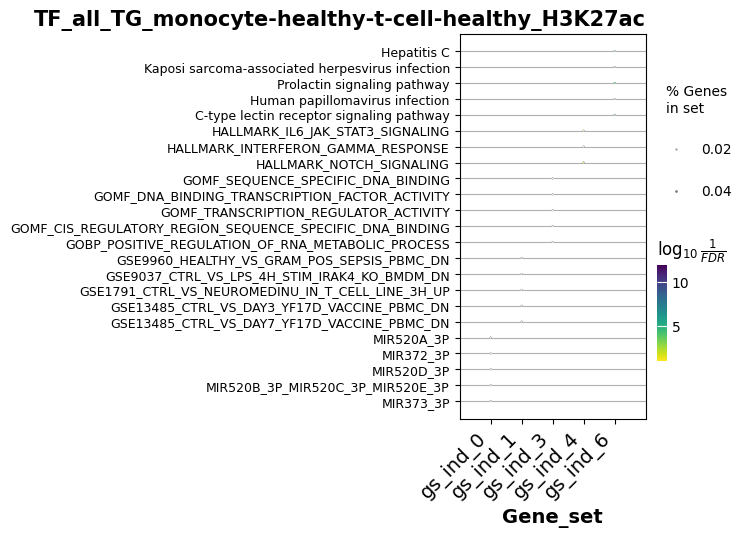

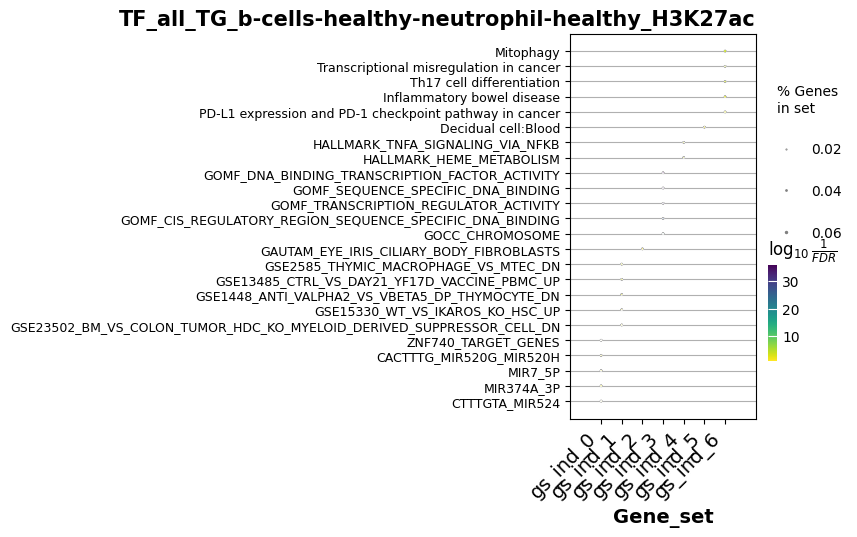

In [43]:
healthy_cells_tf_all_tg_results_dictionary = {}
for index, row in healthy_cells_tf_all_tg_df.iterrows():
    for hm in healthy_cells_tf_all_tg_df.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        if len(genes) > 1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        #background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("TF_all_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_TF_all_TG_"+index+"_"+hm
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                healthy_cells_tf_all_tg_results_dictionary[index+"_"+hm] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+hm)
                print(ve)

## leukemia

-> no differences in set sizes for all TGs or top k TGs; ORA plots are therefore identical

###  top k target genes (nothing interesting found)

In [44]:
df_leukemia_tf_top_k_tgs = df_k27ac_tf_top_k_tg_hgnc.loc[["b-cells-healthy-b-cells-leukemia"]]


#### normal gene sets

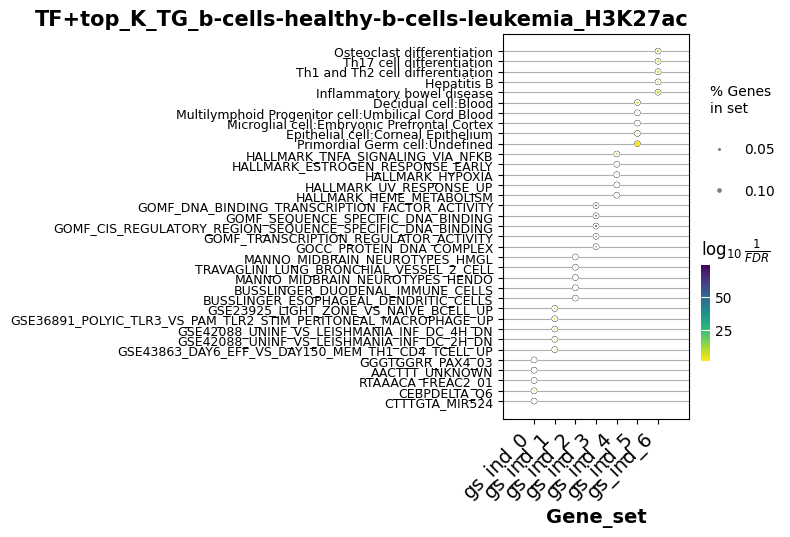

In [46]:
tf_top_k_tg_leukemia_results_dictionary = {}
for index, row in df_leukemia_tf_top_k_tgs.iterrows():
    for hm in df_leukemia_tf_top_k_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=normal_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        #title = index+"_"+tf_type,
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("TF+top_K_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_TF_top_k_TG_"+index+"_"+hm
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            tf_top_k_tg_leukemia_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

#### cancer gene sets

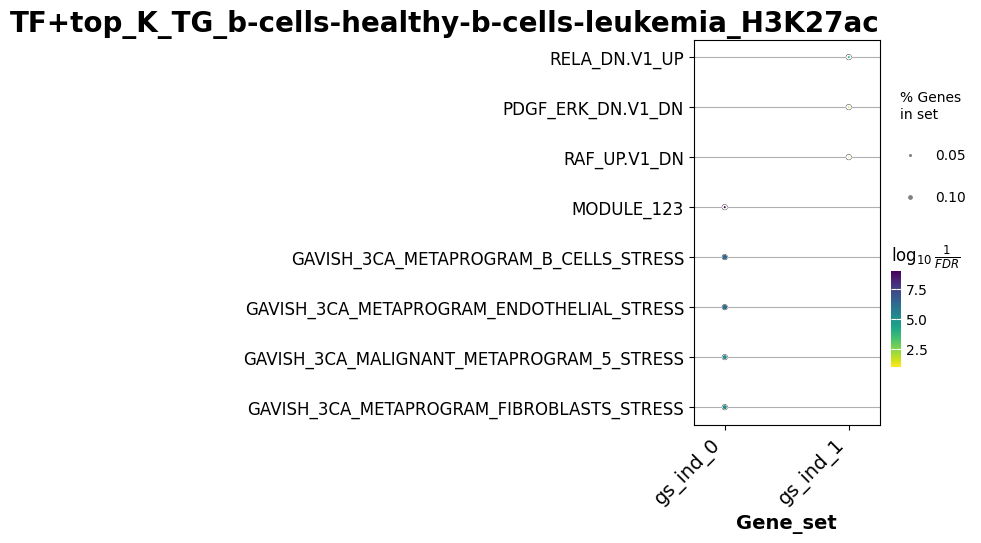

In [47]:
tf_top_k_tg_leukemia_cancer_sets_results_dictionary = {}
for index, row in df_leukemia_tf_top_k_tgs.iterrows():
    for hm in df_leukemia_tf_top_k_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=cancer_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        #title = index+"_"+tf_type,
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("TF+top_K_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_TF_top_k_TG_"+index+"_"+hm+"_cancer_sets"
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            tf_top_k_tg_leukemia_cancer_sets_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

### all target genes (nothing interesting found)

In [48]:
df_leukemia_tf_all_tgs = df_k27ac_tf_all_tgs_hgnc.loc[["b-cells-healthy-b-cells-leukemia"]]

#### normal gene sets

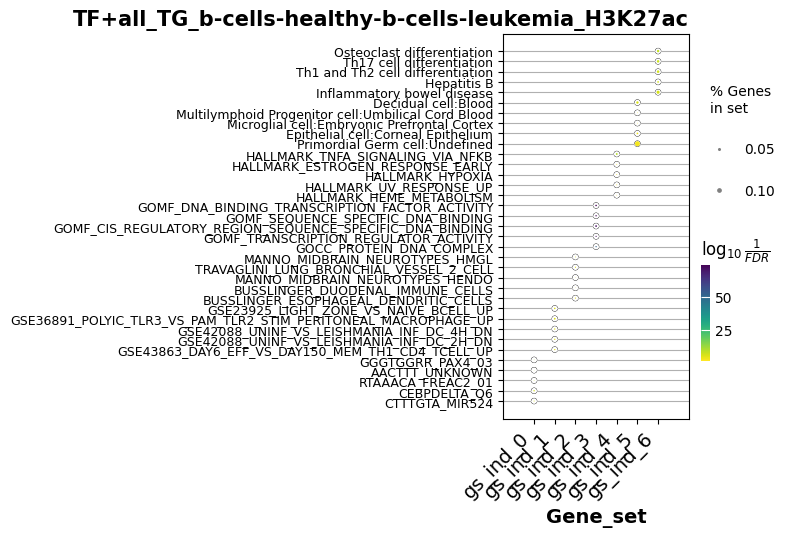

In [49]:
tf_all_tg_leukemia_results_dictionary = {}
for index, row in df_leukemia_tf_all_tgs.iterrows():
    for hm in df_leukemia_tf_all_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=normal_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        #title = index+"_"+tf_type,
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("TF+all_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_TF_all_TG_"+index+"_"+hm
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            tf_all_tg_leukemia_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

#### cancer gene sets

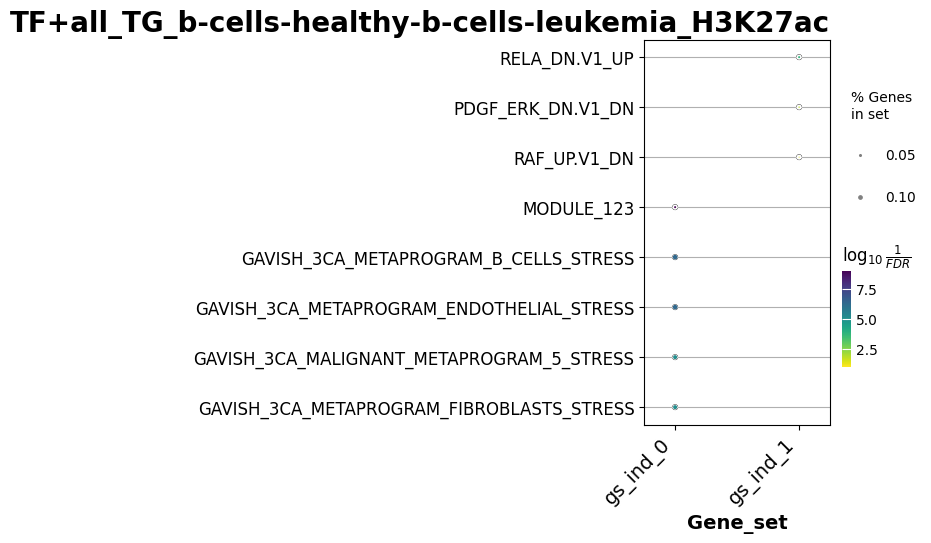

In [50]:
tf_all_tg_leukemia_cancer_sets_results_dictionary = {}
for index, row in df_leukemia_tf_all_tgs.iterrows():
    for hm in df_leukemia_tf_all_tgs.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[hm]))
        enr_bg = gp.enrichr(gene_list=genes,
                    gene_sets=cancer_gene_sets,
                    organism='human', # organism argment is ignored because user input a background
                    #background=all_tfs_adjusted,
                    outdir=None, # don't write to disk
                    )
        try:
            ax = gp.dotplot(enr_bg.results,
                        column="Adjusted P-value",
                        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                        size=4,
                        top_term=5,
                        figsize=(3,5),
                        #title = index+"_"+tf_type,
                        xticklabels_rot=45, # rotate xtick labels
                        show_ring=True, # set to False to revmove outer ring
                        marker='o',
                        )
            y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
            ax.tick_params(axis='y', labelsize=y_axis_size)
            ax.set_title("TF+all_TG_"+index+"_"+hm, loc="right", fontsize=title_size,fontweight='bold')
            figure_file_name = "ORA_TF_all_TG_"+index+"_"+hm+"_cancer_sets"
            plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
            tf_all_tg_leukemia_cancer_sets_results_dictionary[index+"_"+hm] = enr_bg.results
        except ValueError as ve:
            print("For "+str(index)+"_"+hm)
            print(ve)

# testing

In [36]:
def read_out_filtered_target_genes_df(tf_df, all_comparisons_path, modus:Union["all_genes", "top_k_genes"]="top_k_genes", affinity_filter_value=0.05, tf_per_hm=False, per_cell_type=False):
    """Reads out the target genes above the set affinity_filter_value. Either using the top_k_genes from the output folder or the files  from the input folder in 
    org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes

    """
    tf_dict = tf_df.to_dict("index")
    tf_filtered_tg_dict={}
    dir_list = [path.path for path in os.scandir(all_comparisons_path) if path.is_dir()]
    for comparison, values in tf_dict.items():
        if comparison not in tf_filtered_tg_dict.keys():
            tf_filtered_tg_dict[comparison] = {}
            for col_name in tf_df.columns:
                tf_filtered_tg_dict[comparison][col_name] = list()

        for dir in dir_list:
            if comparison in dir:
                comparison_path = os.path.join(all_comparisons_path, dir)
                base_dir = os.path.join(comparison_path, "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes")
                if modus == "top_k_genes":
                    for mode, tf_list in values.items():
                        #print(mode)
                        tf_files_list = [tf+".tsv" for tf in tf_list]
                        if per_cell_type:
                            gene_base_dir = os.path.join(base_dir, "output", comparison)
                        else:
                            gene_base_dir = os.path.join(base_dir, "output")
                        
                        for root, dirs, files in os.walk(gene_base_dir):
                            if tf_per_hm:
                                if os.path.basename(root) != mode:
                                    print("no file used from: "+os.path.basename(root))
                                    continue
                            else:
                                if mode == "active_marks" and any(hm_marker in dirs for hm_marker in ["H3K9me3", "H3K27me3"]):
                                        #print(root)
                                        #print("no TGs for: "+mode+" in dir: "+' '.join(dirs))
                                        continue
                                elif mode == "suppressive_marks" and any(hm_marker in dirs for hm_marker in ["H3K4me1", "H3K4me3", "H3K27ac", "H3K36me3"]):
                                        #print(root)
                                        #print("no TGs for: "+mode+" in dir: "+' '.join(dirs))
                                        continue
                            for tf_file in files:
                                if tf_file in tf_files_list:
                                    print(os.path.basename(root))
                                    print(root)
                                    print(tf_file)
                                    tf_file_path = os.path.join(root, tf_file)
                                    file = pd.read_csv(tf_file_path, sep="\t")
                                    file = file[file["Affinity"]>=affinity_filter_value]
                                    new_tgs = file["Gene"].tolist()
                                    tf_filtered_tg_dict[comparison][mode].extend(new_tgs)
            
                elif modus == "all_genes":
                    if per_cell_type:
                        gene_base_dir = os.path.join(base_dir, "input", comparison)
                    else:
                        gene_base_dir = os.path.join(base_dir, "input")
                    for root, dirs, files in os.walk(gene_base_dir):
                        for tg_matrix in files:
                            if tg_matrix == "dcg.tsv":
                                continue
                            tg_matrix_path = os.path.join(root, tg_matrix)
                            tg_matrix_df = pd.read_csv(tg_matrix_path,  sep="\t")
                            for mode, tf_list in values.items():
                                if tf_per_hm:
                                    if mode not in tg_matrix:
                                        print("file "+str(tg_matrix)+" not used for "+ mode)
                                        continue
                                else:
                                    if mode == "active_marks" and any(hm_marker in tg_matrix for hm_marker in ["H3K9me3", "H3K27me3"]):
                                        #print("no TGs for: "+mode+" in file: "+tg_matrix)
                                        continue
                                    if mode == "suppressive_marks" and any(hm_marker in tg_matrix for hm_marker in ["H3K4me1", "H3K4me3", "H3K27ac", "H3K36me3"]):
                                        #print("no TGs for: "+mode+" in file: "+tg_matrix)
                                        continue
                                for tf in tf_list:
                                    if tf in tg_matrix_df.columns:
                                        new_tgs = tg_matrix_df[tg_matrix_df[tf]>=affinity_filter_value]["Gene"].tolist()
                                        tf_filtered_tg_dict[comparison][mode].extend(new_tgs)
    tg_df =  pd.DataFrame.from_dict(tf_filtered_tg_dict, orient="index")        

    return tg_df